# SeSiMe
### Sentence/Sequence Similarity Measure

## Goal:  Compare/benchmark different similarity measures for MS-MS spectra
Dataset here: GNPS Dataset of 11134 spectra with smiles.

### Parts:
1. Importing, creating documents
2. For benchmarking: Molecular similarity
3. Spec2Vec
4. For comparison: cosine score
5. For comparison: modified cosine score

## 1. Importing, creating documents

In [1]:
# data locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
#mgf_file = PATH_MS_DATA + "GNPSLibraries_allSMILES.mgf"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
# Import / Load data
results_file = "filtered_data_unique_smiles_minpeak10_loss500_2dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0.01, #0
                 exp_intensity_filter = None, #0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


### Documents

+ Peaks were removed using an exponential fit to the peak intensity distribution. 
+ Words were created using 2 decimals.

### Interesting to note: 
+ Not discriminating between **loss** and **peak** has only very little influence on final result. Test was done with naming all peaks and losses by "mz_....". See load_MGF_data function using parameter: peak_loss_words = ['mz_', 'mz_']

In [4]:
# Have a look at how a document looks like:
print(MS_documents[0])

['peak_74.73', 'peak_79.02', 'peak_89.02', 'peak_89.04', 'peak_90.05', 'peak_95.05', 'peak_98.98', 'peak_105.04', 'peak_107.05', 'peak_117.03', 'peak_118.04', 'peak_134.67', 'peak_135.05', 'peak_135.28', 'peak_136.05', 'peak_137.00', 'peak_137.15', 'peak_145.03', 'peak_147.12', 'peak_160.09', 'peak_161.08', 'peak_162.59', 'peak_163.04', 'peak_163.08', 'peak_163.29', 'peak_164.04', 'peak_165.00', 'peak_165.40', 'peak_166.30', 'peak_167.15', 'peak_168.17', 'peak_172.58', 'peak_175.08', 'peak_181.06', 'peak_229.03', 'peak_237.01', 'peak_330.10', 'peak_330.14', 'loss_92.10', 'loss_100.08', 'loss_148.05', 'loss_154.04', 'loss_156.53', 'loss_160.95', 'loss_161.96', 'loss_162.81', 'loss_163.71', 'loss_164.11', 'loss_165.07', 'loss_165.82', 'loss_166.03', 'loss_166.07', 'loss_166.52', 'loss_168.04', 'loss_169.03', 'loss_182.00', 'loss_184.08', 'loss_191.96', 'loss_192.11', 'loss_193.07', 'loss_193.84', 'loss_194.07', 'loss_194.44', 'loss_211.07', 'loss_212.08', 'loss_222.06', 'loss_224.07', 'l

In [5]:
len(MS_documents)  # number of spectra = number of documents

9550

### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [6]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [7]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  67429


### Note
In total it would be about 100.000 words. Many occur only once in the entire corpus and are hence filtered out (makes not sense to place them somewhere in word-space, would be arbitrary!).

Few also are filtered out because they occur too often (in more than 20% of the spectra). Those words have little discriminative power and are hence ignored. Might still be worth keeping them in for comparison!

## 2. For benchmarking: molecular similarity
Benchmarking - Reference score is molecular similarity (based on mol. fingerprints)

### Calculate molecular fingerprints
Here using: morgen-3 (alternative would be "daylight")  
Method will have problems with some smiles, those will be excluded from further analysis.

In [10]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

### Get molecular similarity matrix (based on molecular fingerprints).  
Here used: Tanimoto scores for daylight fingerprints. And dice score for morgan-3 fingerprints.

In [11]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
molecular_similarities = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints_m3,
                                                      filename = filename)

Molecular similarity scores found and loaded.


#### Baseline: Histogram of all Tanimoto/Dice scores

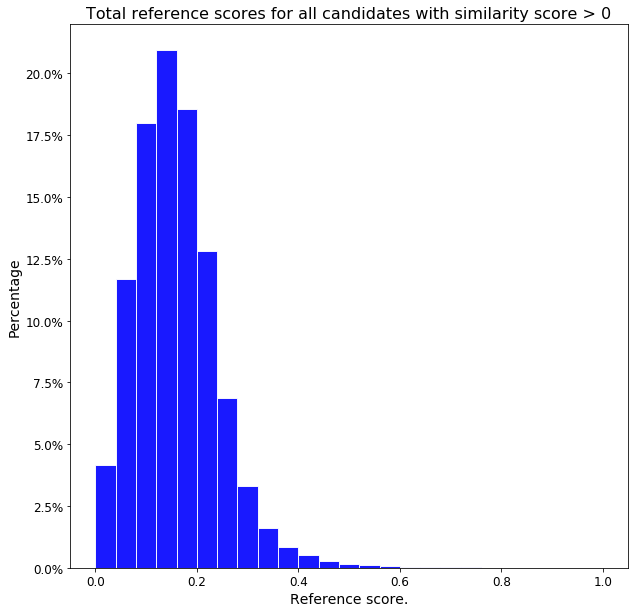

In [17]:
n, bins = MS_functions.similarity_histogram(tanimoto_similarities, tanimoto_similarities, 0, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_baseline.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

--> Based on this plot we can argue that we set the threshold between low- and high-molecular-similarity at **Dice(morgan3) = 0.5**.

## 3. Spec2Vec
### 3.1 Model trained on dataset itself (unique smiles)

In [8]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [9]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents. Calculated centroid vectors for  1710  of  9550  documents. Calculated centroid vectors for  2880  of  9550  documents. 3030  of  9550  documents.  documents. Calculated centroid vectors for  9040  of  9550  documents.

### Get all-vs-all matrix of similarity scores

In [15]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

## Plotting functions: 

In [69]:
import matplotlib
from matplotlib import pyplot as plt

def binned_scatter_plot(bins_x, 
                        bins_y, 
                        H, 
                        edges, 
                        label):
    data_x = []
    data_y = []
    data_z = []
    data_y_mean = []
    for i in range(bins_x):
        for j in range(bins_y):
            data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
            data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
            mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
            data_y_mean.append(mean_mol_score)
            data_z.append(np.sum(H[i,j]))#/np.sum(H[i,:]))
            
    fig, ax = plt.subplots(figsize=(15,10))
    cm = plt.cm.get_cmap('viridis')
    #100*np.array(data_z)**0.5 c=data_y, 
    ax.scatter(data_x, data_y, s=1*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.6)
    plt.plot(data_x, data_y_mean, color='black')
    plt.xlabel("g(s,s') (" + label + ")")
    plt.ylabel("molecular similarity (f(t,t'))")

    # Optionally add a colorbar
    max_color = np.max(data_y)
    min_color = np.min(data_y)
    color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.ax.set_yticklabels([x for x in list(color_ticks)])
    plt.ylabel("molecular similarity (f(t,t'))")

In [92]:
def plot_high_sim_fraction(H, edges, label):
    high_low_sim_fraction = []
    for i in range(H.shape[0]):
        low_frac = np.sum(H[i,:12])/np.sum(H[i,:])
        high_frac = np.sum(H[i,12:])/np.sum(H[i,:])
        high_low_sim_fraction.append((low_frac, high_frac))

    fig, ax = plt.subplots(figsize=(6,6))
    _, high_perc = zip(*high_low_sim_fraction)
    high_perc = 100*np.array(high_perc)
    plt.plot(edges[0][:-1], high_perc, color='black')
    plt.xlabel("g(s,s') (" + label + ")")
    plt.ylabel("fraction of highly molecular similarity in % (morgan3 > 0.48)")
    
    return high_perc

In [219]:
def plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 1.0):
    
    top_bin_cutoff = int(num_bins*show_top_percentile/100) 
    hist, bin_edges = np.histogram(A, histedges_equalN(A, num_bins))
    
    ref_score = []
    ref_score_cum = []
    for i in range(top_bin_cutoff):    
        ref_score.append(np.mean(B[np.where((A > bin_edges[-(i+2)]) & (A < bin_edges[-(i+1)]))]))
        ref_score_cum.append(np.mean(B[np.where((A > bin_edges[-(i+2)]))]))
    ref_score = np.array(ref_score)
    ref_score_cum = np.array(ref_score_cum)
                         
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot((1/100*(1+np.arange(top_bin_cutoff))), ref_score_cum, color='black')
    plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cum, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
    #plt.xlim(show_top_percentile, 0)
    
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot((1/100*(1+np.arange(top_bin_cutoff))), ref_score, color='black')
    plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') at that percentile)")
    #plt.xlim(show_top_percentile, 0)
    
    return ref_score, ref_score_cum

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

In [110]:
remove_diagonal = []
length = M_sim_ctr.shape[0]
for i in range(length):
    remove_diagonal.append(i*length + i)

remove_diagonal = np.array(remove_diagonal)    

1.0

In [166]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

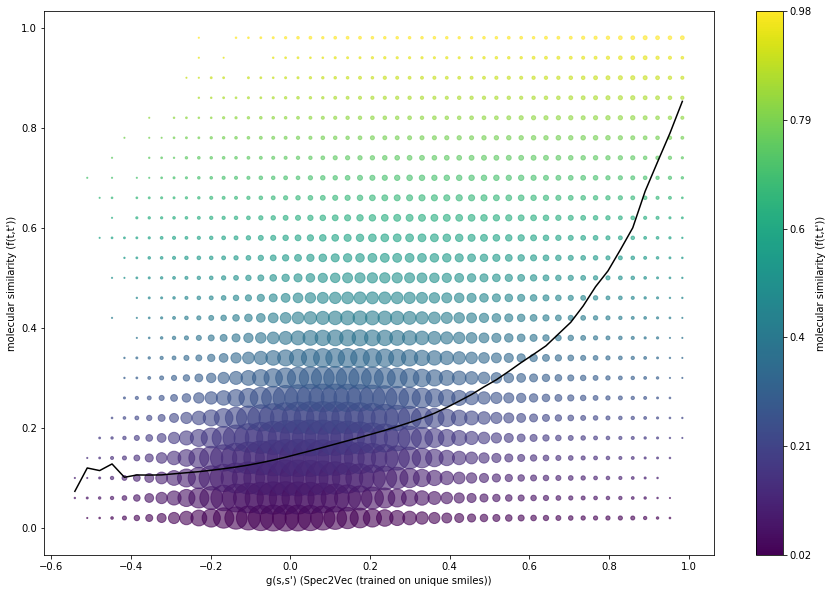

In [114]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on unique smiles)")

## The above plot is an UPDATED version!
Before all values from the all-vs-all similarity matrix were included. Hence also the values for spectra with themselves! For these entirely identical pairs, all methods (cosine, modified cosine, Word2Vec, and morgan-3) usually give only 1.0, so that's pretty boring and better to leave out (I would say...).

See below one of the plots as I made them before, for comparison.

In [94]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           M_sim_morgan3.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

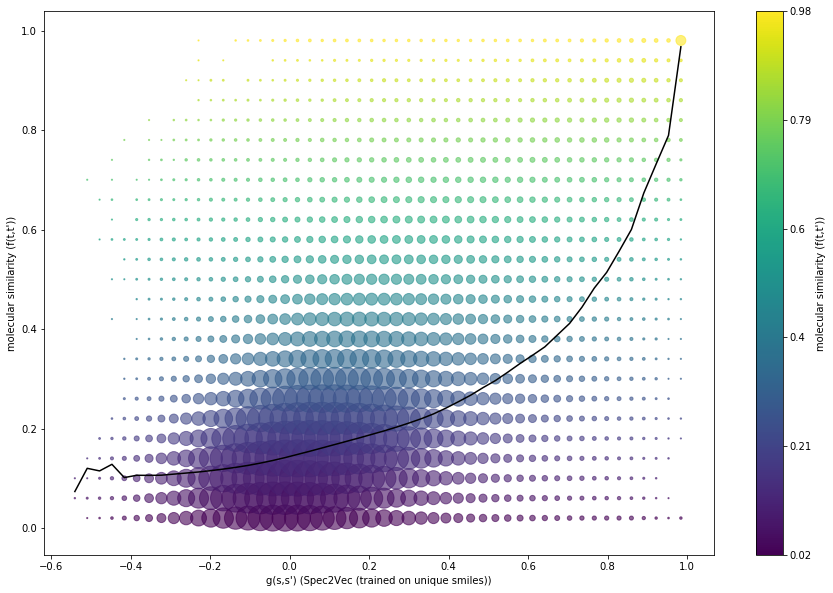

In [95]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on unique smiles)")

Set similarity threshold to:  0.8505918971390208


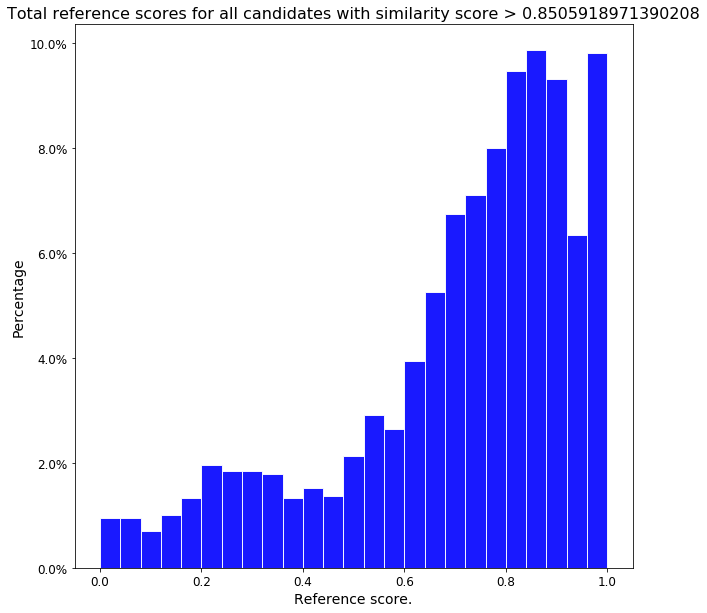

Percentage of highly similar molecules within selection:  83.4 %


In [22]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Potential issue: The choice of selection the 10.000 best similarity pairs is of course arbitrary. 
Maybe we can use another plot like the next instead?

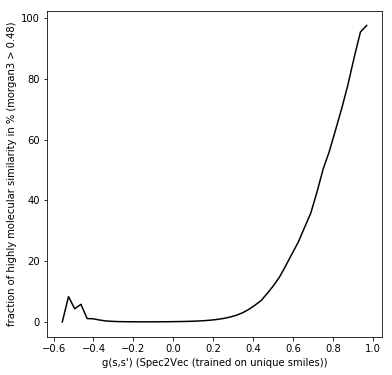

In [115]:
label = "Spec2Vec (trained on unique smiles)"

high_perc_w2v1 = plot_high_sim_fraction(H, edges, label)

### Possibly even better could be something like this:

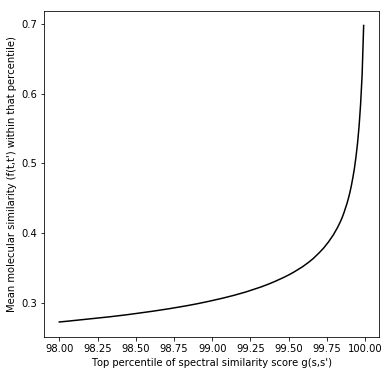

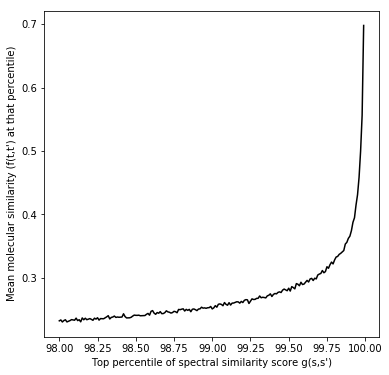

In [220]:
ref_score_w2v, ref_score_w2v_cum = plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 2.0)

## 4. For comparison: cosine score

Load (or calculate) the cosine score matrix.

### 4.1 Cosine score based on gnps default 1 (tol = 0.5, min_match = 6)

In [224]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol05_minmatch6.npy"
M_sim_cosine = MS_functions.cosine_matrix(spectra, 
                                          tol = 0.5, 
                                          max_mz = 1000, 
                                          min_mz = 0, 
                                          min_match = 6, 
                                          min_intens = 0,
                                          filename = filename,
                                          num_workers = 4)

Complete cosine similarity scores found and loaded.


In [221]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_cosine.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

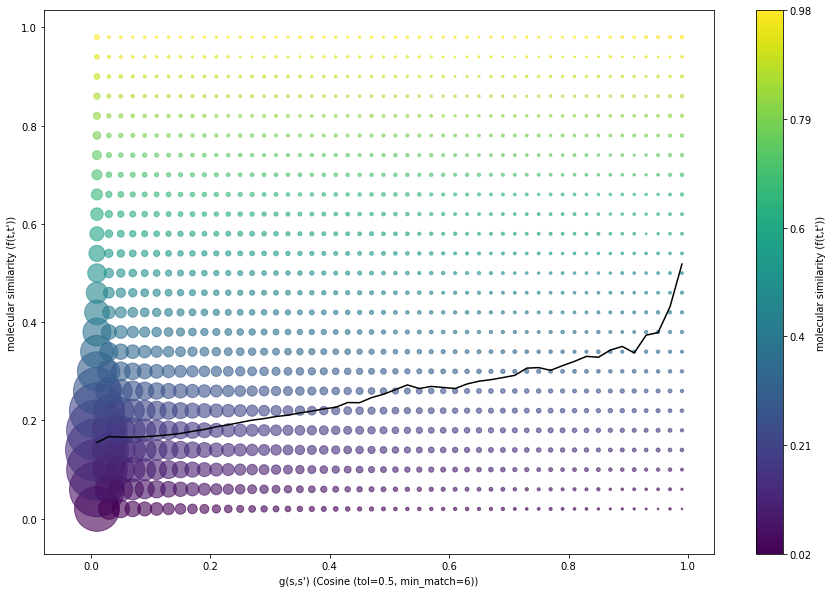

In [160]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Cosine (tol=0.5, min_match=6)")

Set similarity threshold to:  0.8505918971390208


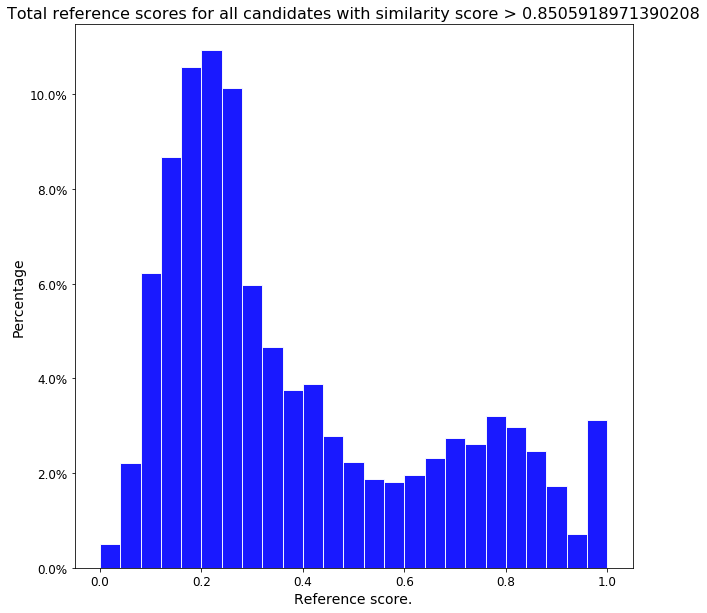

Percentage of highly similar molecules within selection:  29.7 %


In [26]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_ctr.reshape(M_sim_cosine.shape[0]**2))[-(num_best + M_sim_cosine.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_cosine, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_cosine_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

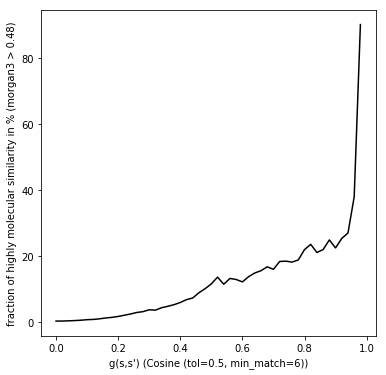

In [93]:
label = "Cosine (tol=0.5, min_match=6)"
high_perc_cosine1 = plot_high_sim_fraction(H, edges, label)

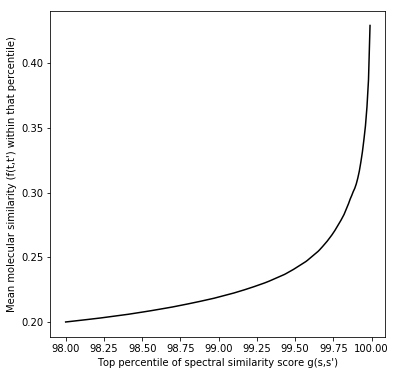

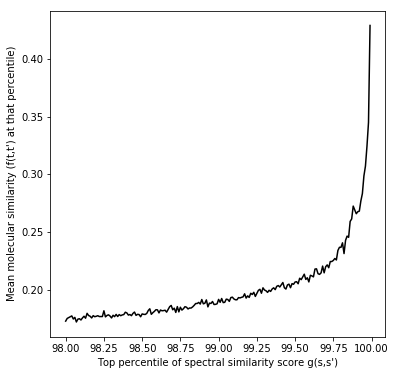

In [222]:
ref_score_cosine, ref_score_cosine_cum = plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 2.0)

### 4.2 Cosine score based on gnps default 2 (tol = 0.02, min_match = 6)

In [225]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol002_minmatch6.npy"
M_sim_cosine2 = MS_functions.cosine_matrix(spectra, 
                                          tol = 0.02, 
                                          max_mz = 1000, 
                                          min_mz = 0, 
                                          min_match = 6, 
                                          min_intens = 0,
                                          filename = filename,
                                          num_workers = 4)

Complete cosine similarity scores found and loaded.


In [226]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_cosine2.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

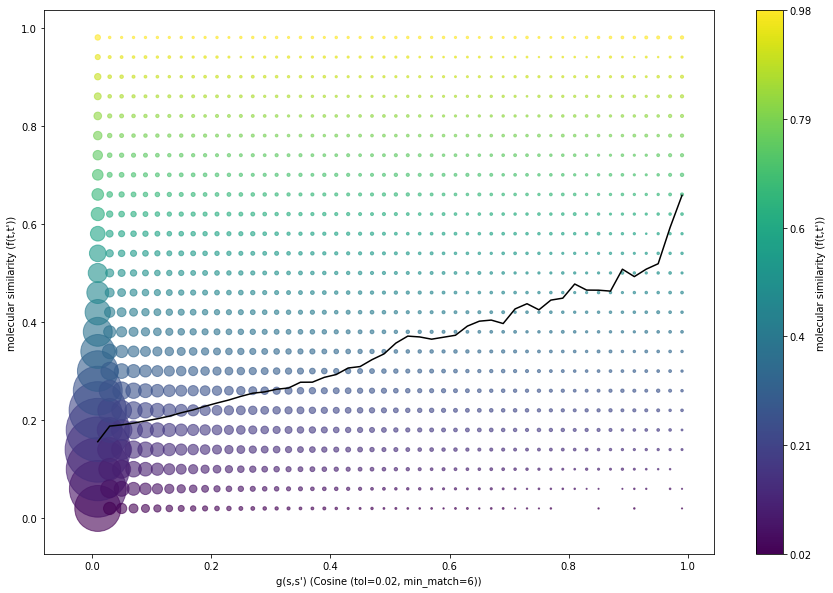

In [227]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Cosine (tol=0.02, min_match=6)")

Set similarity threshold to:  0.8505918971390208


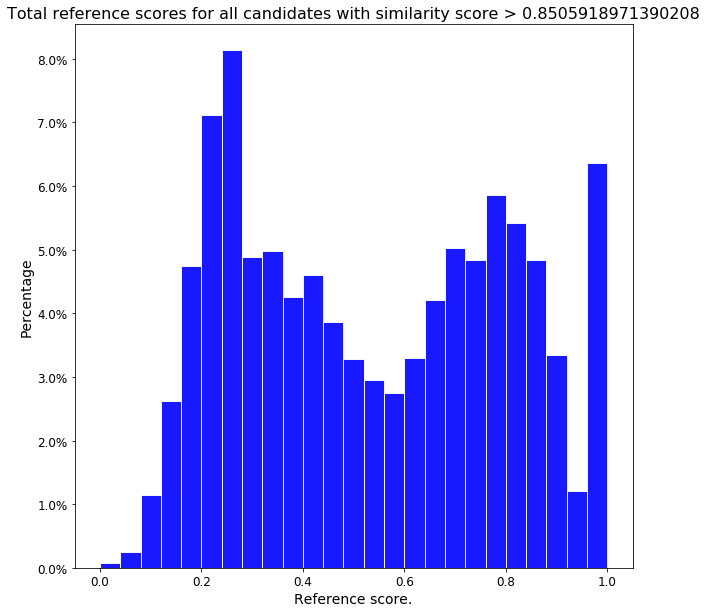

Percentage of highly similar molecules within selection:  53.36 %


In [228]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_ctr.reshape(M_sim_cosine2.shape[0]**2))[-(num_best + M_sim_cosine2.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_cosine2, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_cosine_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

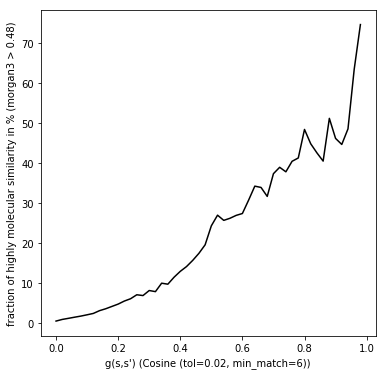

In [229]:
label = "Cosine (tol=0.02, min_match=6)"
high_perc_cosine1 = plot_high_sim_fraction(H, edges, label)

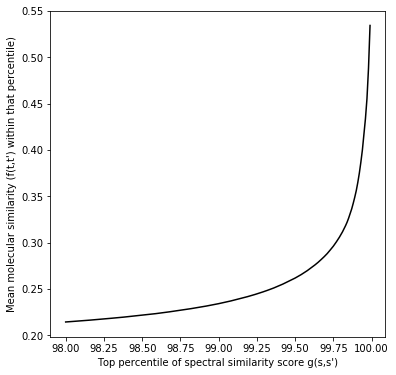

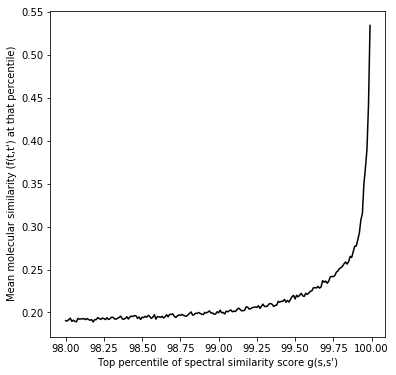

In [230]:
ref_score_cosine2, ref_score_cosine_cum2 = plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 2.0)

## 5. For comparison: modified cosine score

Load (or calculate if not present yet) the **Mol.Net** score matrix (carefull, calculating from scratch is slow!).

### 5.1 Mod. Cosine score based on gnps default 1 (high tol)

In [13]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol05_minmatch6_fast.npy"
M_sim_molnet = MS_functions.molnet_matrix(spectra, 
              tol = 0.5, 
              max_mz = 1000, 
              min_mz = 0, 
              min_match = 6, 
              min_intens = 0.01,
              filename = filename,
              method = 'fast',
              num_workers = 8,
              safety_points = 50)

Uncomplete MolNet similarity scores found and loaded.
Missing MolNet scores will be calculated.
About  93.9340610180642 % of the values already completed.
Calculate pairwise MolNet scores by  8 number of workers.


C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\MS_functions.py:1559: RuntimeWarning: overflow encountered in long_scalars
  print('\r', ' Calculated MolNet for pair ', i, '--', j, '. ( ', np.round(200*(counter+1)/len_spectra**2, 2), ' % done).', end="")


  Calculated MolNet for pair  9480 -- 9508 . (  5.81  % done).. (  5.75  % done)..68  % done).60 -- 7476 . (  5.54  % done).  % done). % done). -- 3326 . (  0.02  % done). 725 -- 6513 . (  0.07  % done). 725 -- 9513 . (  0.07  % done).-- 3778 . (  0.17  % done). 0.18  % done).. (  0.22  % done).. (  0.24  % done). 6953 . (  0.33  % done). 1092 -- 8495 . (  0.35  % done). % done).0.42  % done).0.46  % done). 0.49  % done). 0.52  % done).1162 -- 4943 . (  0.55  % done). . (  0.74  % done).6377 . (  0.75  % done). 8111 . (  0.77  % done).. (  0.78  % done). Calculated MolNet for pair  1345 -- 1957 . (  0.85  % done).1345 -- 4957 . (  0.86  % done).0.86  % done).. (  0.98  % done).1.03  % done).3996 . (  1.07  % done). 1.09  % done).1470 --  1.14  % done).1.16  % done). % done).1594 -- 4642 . (  1.37  % done). Calculated MolNet for pair  1594 -- 8642 . (  1.38  % done).7710 . (  1.39  % done). . (  1.4  % done).. (  1.45  % done).. (  1.47  % done).-- 5143 . (  1.47  % done).1.52  % done).

In [231]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_molnet.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

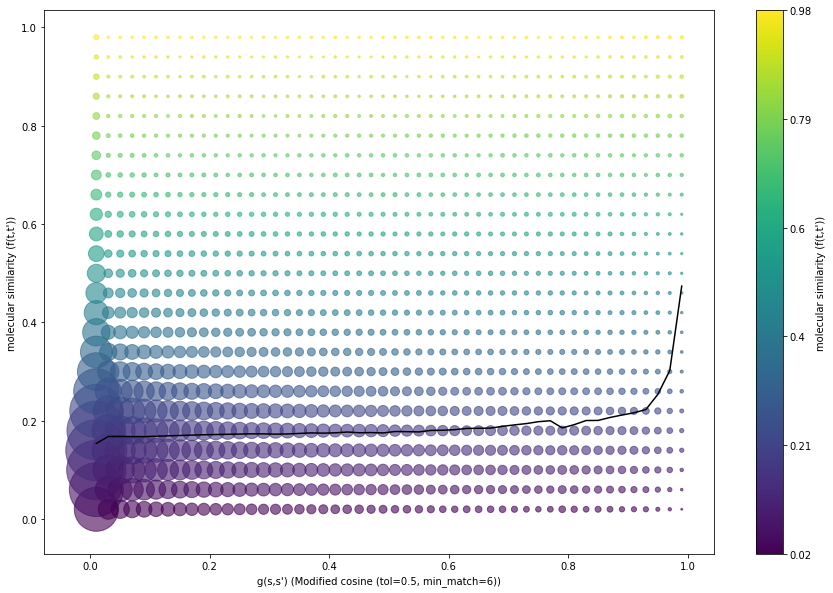

In [232]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Modified cosine (tol=0.5, min_match=6)")

Set similarity threshold to:  0.9590343842767778


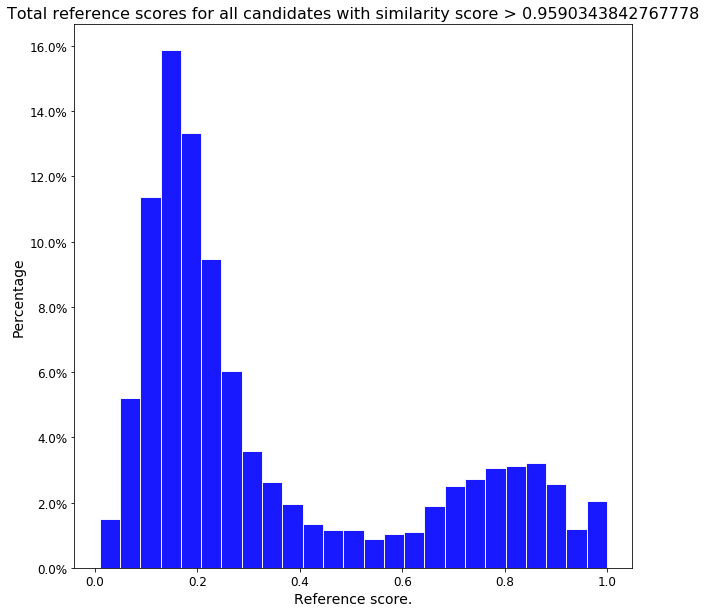

Percentage of highly similar molecules within selection:  26.55 %


In [30]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_molnet.reshape(M_sim_molnet.shape[0]**2))[-(num_best + M_sim_molnet.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_molnet, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_molnet_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

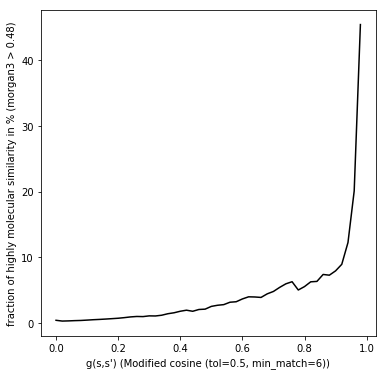

In [233]:
label = "Modified cosine (tol=0.5, min_match=6)"
high_perc_molnet1 = plot_high_sim_fraction(H, edges, label)

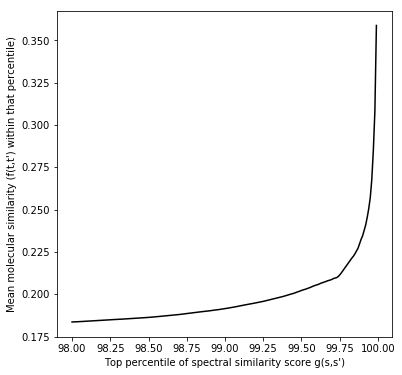

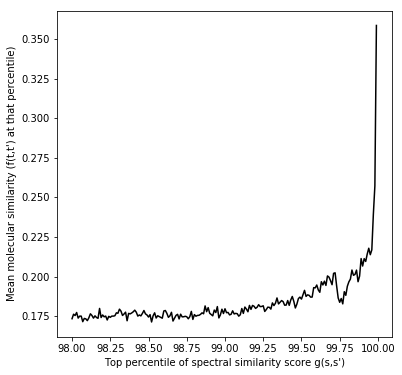

In [234]:
ref_score_molnet1, ref_score_molnet1_cum = plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 2.0)

### 5.2 Mod. Cosine score based on gnps default 2 (low tol)

In [32]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol002_minmatch6_fast.npy"
"""M_sim_molnet2 = MS_functions.molnet_matrix(spectra, 
                  tol = 0.02, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 6, 
                  min_intens = 0.01,
                  filename = filename,
                  method = 'fast',
                  num_workers = 8,
                  safety_points = 50)
"""

# or loading without checks:
M_sim_molnet2 = np.load(filename)

In [235]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_molnet2.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

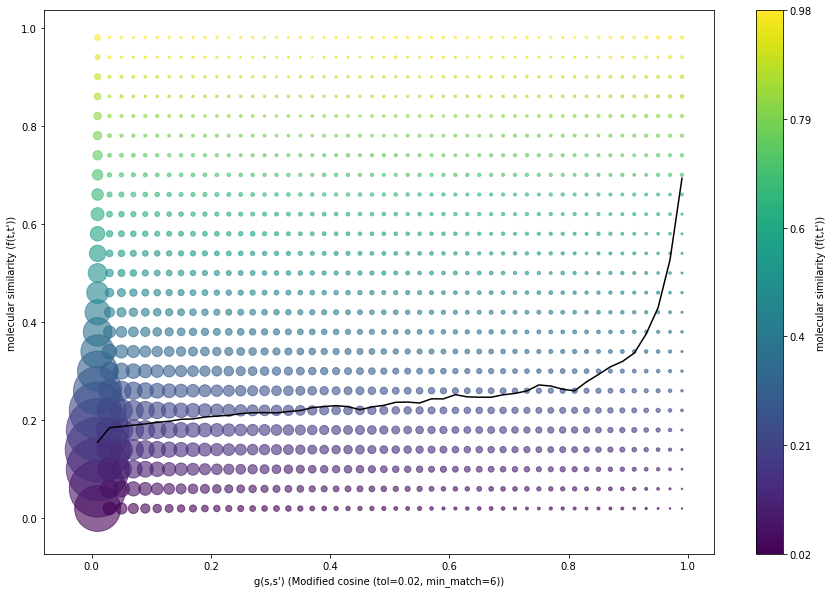

In [236]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Modified cosine (tol=0.02, min_match=6)")

Set similarity threshold to:  0.919214998587065


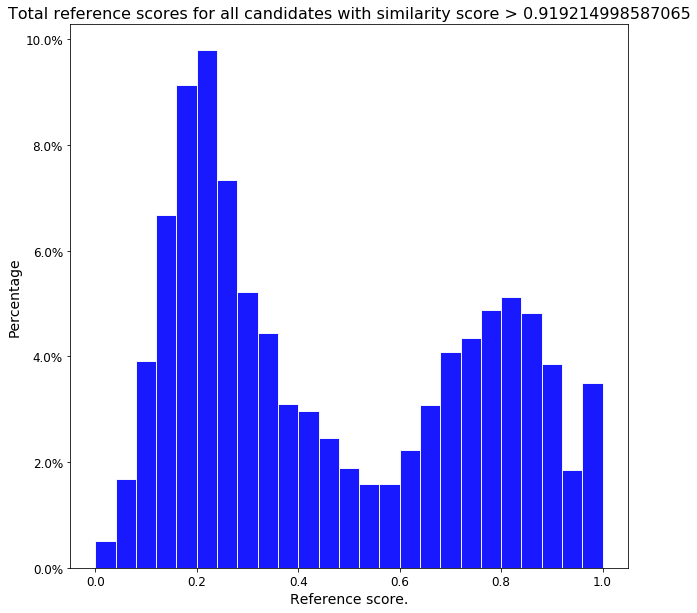

Percentage of highly similar molecules within selection:  42.78 %


In [35]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_molnet2.reshape(M_sim_molnet2.shape[0]**2))[-(num_best + M_sim_molnet2.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_molnet2, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_molnet_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

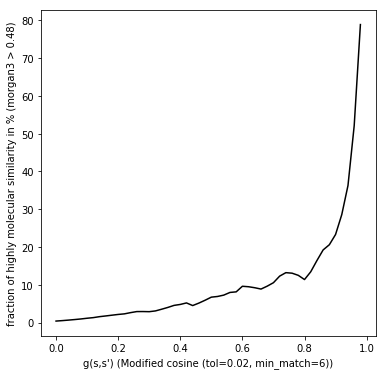

In [237]:
label = "Modified cosine (tol=0.02, min_match=6)"
high_perc_molnet2 = plot_high_sim_fraction(H, edges, label)

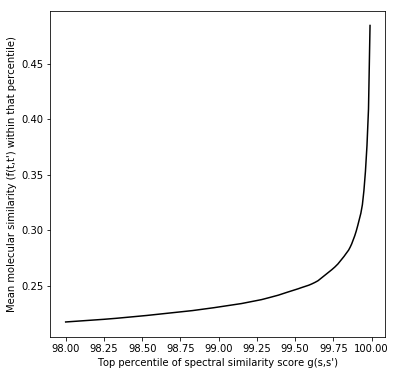

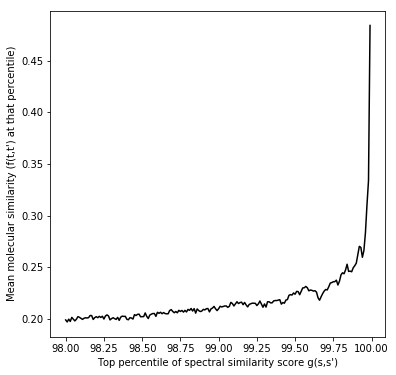

In [238]:
ref_score_molnet2, ref_score_molnet2_cum = plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 2.0)

## Percentile plots combined:

Text(0, 0.5, "Mean molecular similarity (f(t,t') at that percentile)")

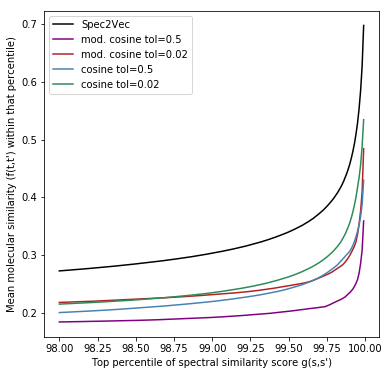

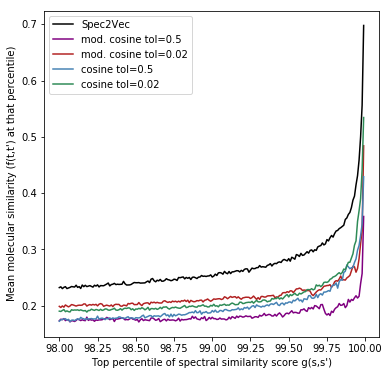

In [245]:
# Compare all:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_w2v_cum, color='black', label='Spec2Vec')
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_molnet1_cum, color='purple', label='mod. cosine tol=0.5')
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_molnet2_cum, color='firebrick', label='mod. cosine tol=0.02')
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cosine_cum, color='steelblue', label='cosine tol=0.5')
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cosine_cum2, color='seagreen', label='cosine tol=0.02')
plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")

fig, ax = plt.subplots(figsize=(6,6))
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_w2v, color='black', label='Spec2Vec')
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_molnet1, color='purple', label='mod. cosine tol=0.5')
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_molnet2, color='firebrick', label='mod. cosine tol=0.02')
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cosine, color='steelblue', label='cosine tol=0.5')
plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cosine2, color='seagreen', label='cosine tol=0.02')
plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') at that percentile)")

### 5.3 Mod. Cosine score (tol = 0.2, min_match = 2)

In [37]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_tol02_minmatch2_minintens_001.npy"
M_sim_molnet3 = MS_functions.molnet_matrix(spectra, 
                  tol = 0.2, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 2, 
                  min_intens = 0.01,
                  filename = filename)

Uncomplete MolNet similarity scores found and loaded.
Missing MolNet scores will be calculated.
About  99.84123242235684 % of the values already completed.
Calculate pairwise MolNet scores by  4 number of workers.
  Calculated MolNet for pair  7182 -- 9299 . (  5.81  % done). 5.73  % done). -- 8268 . (  5.77  % done).

In [81]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_molnet3.reshape(9550**2), 
                           M_sim_morgan3.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

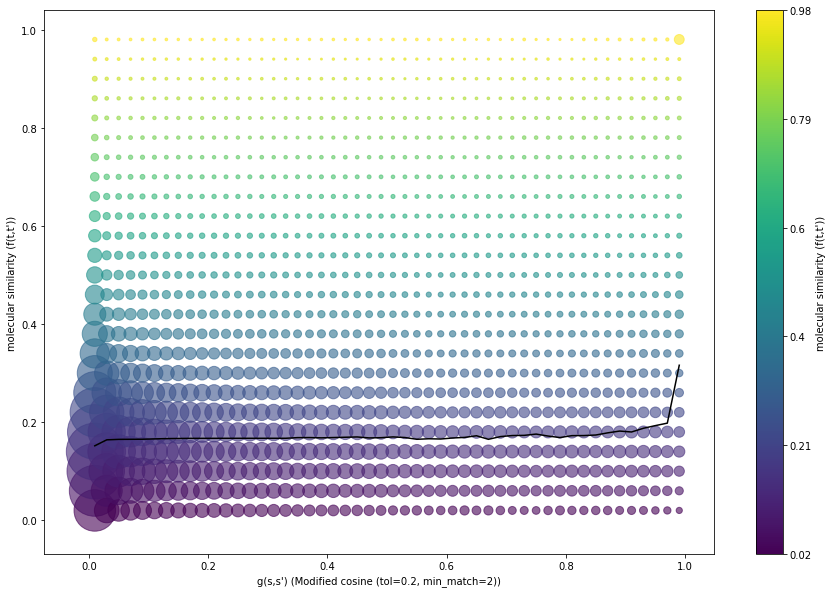

In [70]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Modified cosine (tol=0.2, min_match=2)")

Set similarity threshold to:  0.9956584444975555


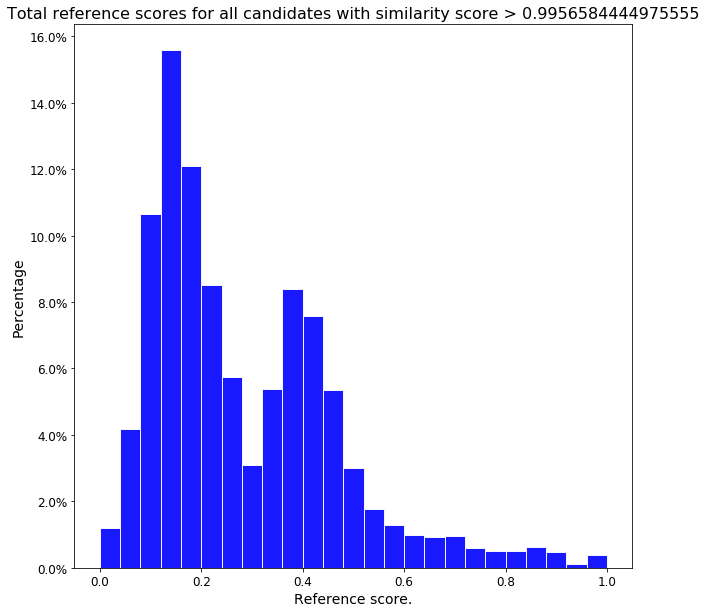

Percentage of highly similar molecules within selection:  12.21 %


In [40]:
num_best = 10000  # arbitrary number, but at least same for all methods...
threshold = np.sort(M_sim_molnet3.reshape(M_sim_molnet3.shape[0]**2))[-(num_best + M_sim_molnet3.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_molnet3, M_sim_morgan3, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_molnet_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

Text(0, 0.5, 'fraction of highly molecular similarity in % (morgan3 > 0.48)')

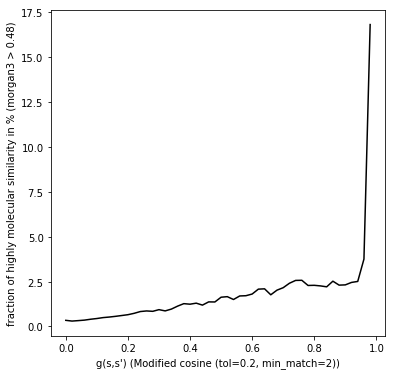

In [76]:
label = "Modified cosine (tol=0.2, min_match=2)"

high_perc = plot_high_sim_fraction(H, edges, label)

# Explore ways to compare the different scores.

Below: many plotting tests that were done...

#### 1) Draw histograms of Tanimoto/Dice scores for the highest scoring similarity pairs. 

#### Baseline: Histogram of all Tanimoto/Dice scores

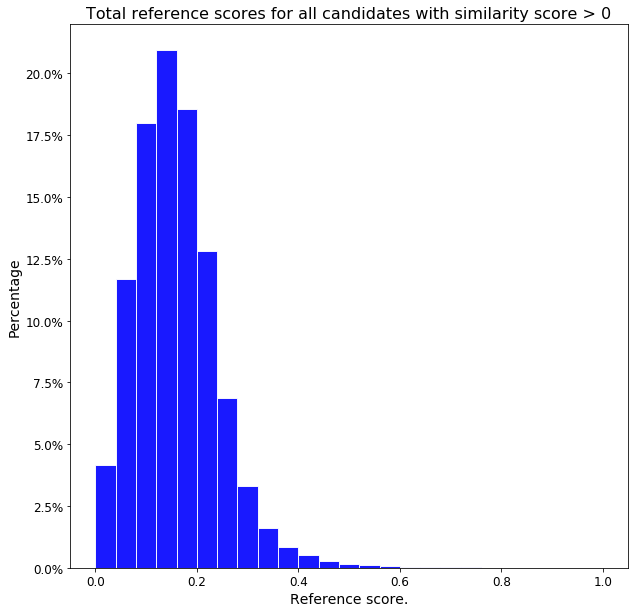

In [17]:
n, bins = MS_functions.similarity_histogram(tanimoto_similarities, tanimoto_similarities, 0, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_baseline.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

#### Top 10000 entries (+ top 5000 candidates) for Mol.Net score:

Set similarity threshold to:  0.9956584444975555


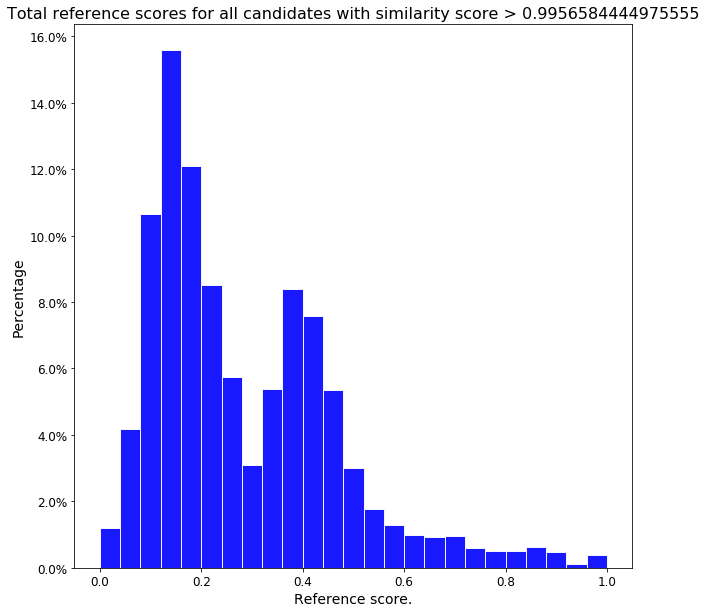

Percentage of highly similar molecules within selection:  12.21 %


In [47]:
num_best = 10000
threshold = np.sort(molnet_sim.reshape(molnet_sim.shape[0]**2))[-(num_best + molnet_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(molnet_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_molnet.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

#### Top 10000 entries (+ top 5000 candidates) for Mol.Net score CALCULATED USING HUNGARIAN ALGORITHM:

In [101]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_tol02_minmatch2_hungarian.npy"
molnet_sim_hung = MS_functions.molnet_matrix(spectra, 
                  tol = 0.2, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 2, 
                  min_intens = 0.01,
                  filename = filename)

Complete MolNet similarity scores found and loaded.


In [48]:
molnet_diff = molnet_sim - molnet_sim_hung

In [83]:
np.mean(np.abs(molnet_diff))

0.00850523235764203

Re-run the fast molnet score with min_match = 1, because now we have to sort out all examples for which we get zeros...

In [82]:
find_outliers = np.where((np.abs(molnet_diff) > 0.01) & (molnet_sim > 0))
find_outliers[0].shape

(11120,)

In [78]:
np.mean(np.abs(molnet_diff[find_outliers])), np.max(np.abs(molnet_diff[find_outliers]))

(0.01960704081489316, 0.30190654364508285)

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 6.000e+00, 4.000e+00, 2.000e+00, 0.000e+00,
        4.000e+00, 4.000e+00, 4.000e+00, 6.000e+00, 0.000e+00, 6.000e+00,
        2.000e+00, 6.000e+00, 4.000e+00, 8.000e+00, 4.000e+00, 4.000e+00,
        8.000e+00, 8.000e+00, 6.000e+00, 4.000e+00, 1.200e+01, 1.400e+01,
        2.000e+01, 1.200e+01, 2.400e+0

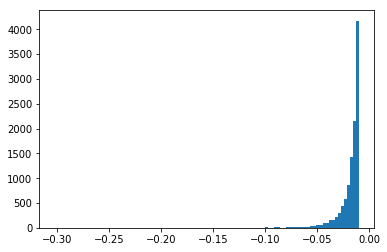

In [76]:
plt.hist(molnet_diff[find_outliers], 100)

Set similarity threshold to:  0.9959569040984543


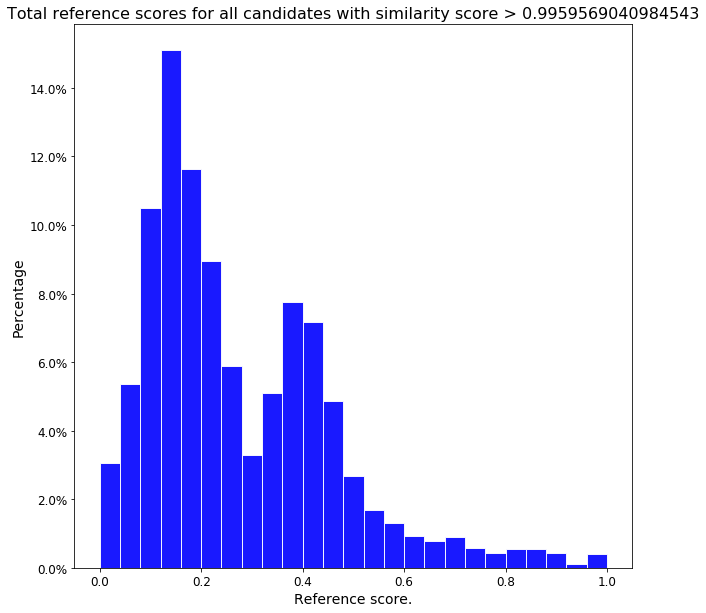

Percentage of highly similar molecules within selection:  11.34 %


In [46]:
num_best = 10000
threshold = np.sort(molnet_sim_hung.reshape(molnet_sim_hung.shape[0]**2))[-(num_best + molnet_sim_hung.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(molnet_sim_hung, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_molnet.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

#### Top 10000 entries (+ top 5000 candidates) for Word2Vec/Centroid score:

Set similarity threshold to:  0.8505918971390208


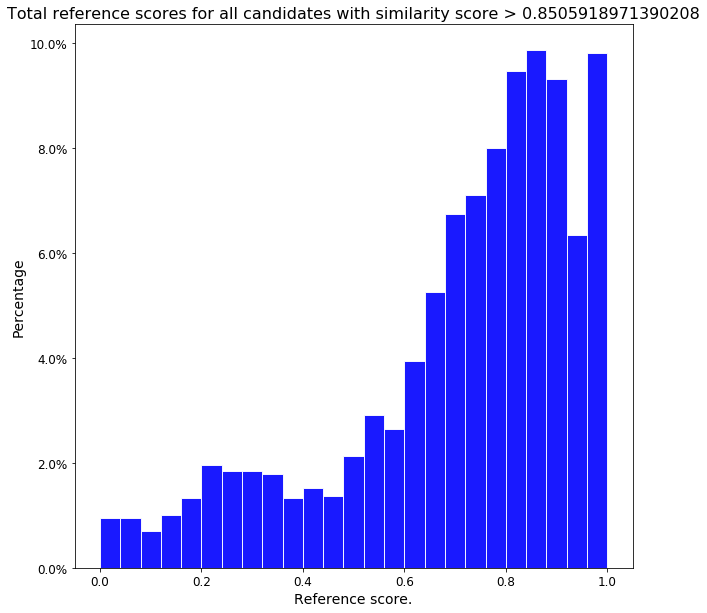

Percentage of highly similar molecules within selection:  83.4 %


In [16]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

#### Theoretical maxium based on Tanimoto/Dice scores only

Set similarity threshold to:  0.8631921824104235


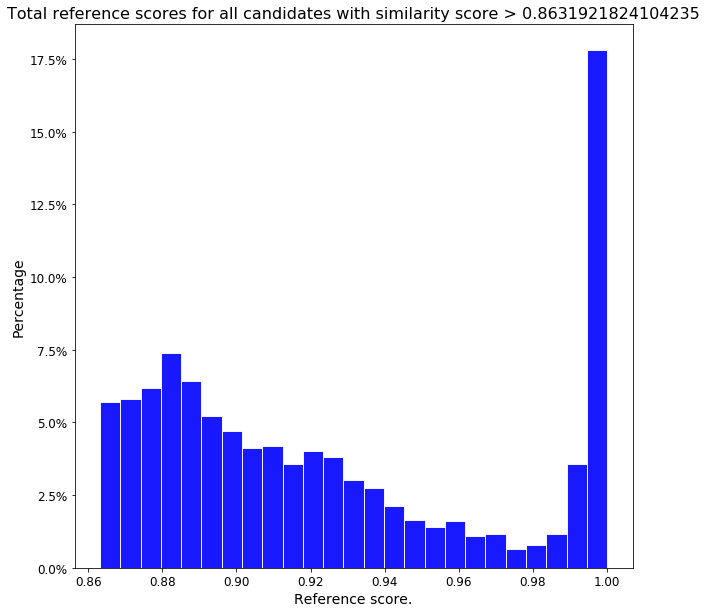

In [20]:
num_best = 10000
threshold = np.sort(tanimoto_similarities.reshape(tanimoto_similarities.shape[0]**2))[-(num_best + tanimoto_similarities.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(tanimoto_similarities, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_maximum.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Compare MolNet score and centroid/Word2Vec score

In [18]:
from matplotlib import pyplot as plt
import matplotlib

In [25]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

Text(0, 0.5, "molecular similarity (f(t,t'))")

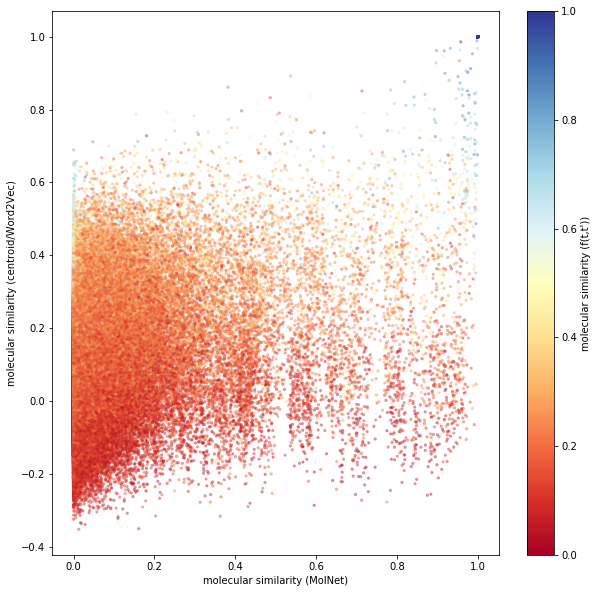

In [21]:
# Agreement between Word2Vec and MolNet similarity.
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')
ax.scatter(molnet_sim[:500,:500], M_sim_ctr[:500,:500], s=5, c=tanimoto_similarities[:500,:500], cmap=cm, alpha=0.2)
plt.xlabel("molecular similarity (MolNet)")
plt.ylabel("molecular similarity (centroid/Word2Vec)")

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm)
plt.ylabel("molecular similarity (f(t,t'))")

Text(0, 0.5, "molecular similarity (f(t,t'))")

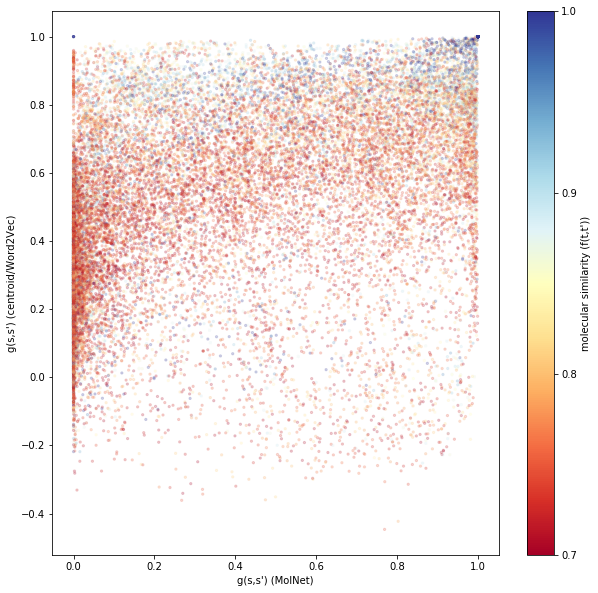

In [28]:
# Agreement between Word2Vec and MolNet similarity.
select = np.where(tanimoto_similarities > 0.7)

fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')
ax.scatter(molnet_sim[select], M_sim_ctr[select], s=5, c=tanimoto_similarities[select], cmap=cm, alpha=0.1)
plt.xlabel("g(s,s') (MolNet)")
plt.ylabel("g(s,s') (centroid/Word2Vec)")

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)

cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.333, 0.666, 1])
cbar.ax.set_yticklabels(['0.7', '0.8', '0.9', '1.0'])
plt.ylabel("molecular similarity (f(t,t'))")

Text(0, 0.5, "molecular similarity (f(t,t'))")

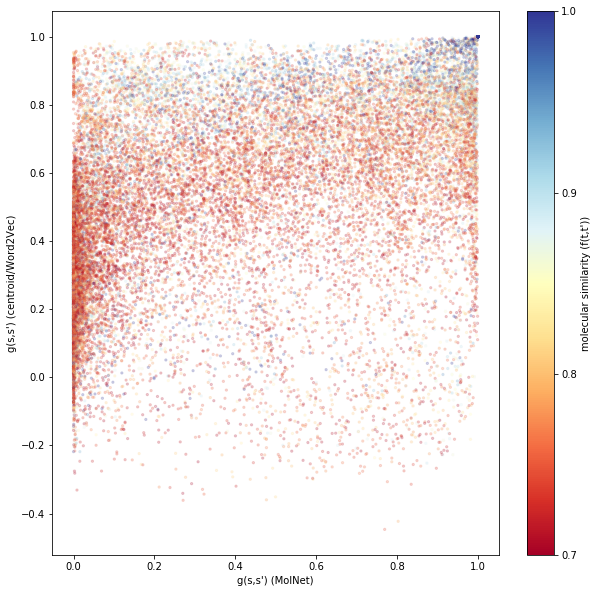

In [31]:
# Agreement between Word2Vec and MolNet similarity.
select = np.where(tanimoto_similarities > 0.7)

fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')
ax.scatter(molnet_sim_hung[select], M_sim_ctr[select], s=5, c=tanimoto_similarities[select], cmap=cm, alpha=0.1)
plt.xlabel("g(s,s') (MolNet)")
plt.ylabel("g(s,s') (centroid/Word2Vec)")

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)

cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.333, 0.666, 1])
cbar.ax.set_yticklabels(['0.7', '0.8', '0.9', '1.0'])
plt.ylabel("molecular similarity (f(t,t'))")

### switch to density based plot

In [212]:
bins_xy = 10
bins_z = 100

H, edges = np.histogramdd([molnet_sim_hung.reshape(9550**2), 
                           M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_xy, bins_xy, bins_z))

In [ ]:
edges

In [213]:
data_x = []
data_y = []
data_z = []
data_z_mean = []
for i in range(bins_xy):
    for j in range(bins_xy):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        data_z.append(np.sum(H[i,j,:])/10000)
        mean_mol_score = np.sum(H[i,j,:]*(edges[2][:bins_z] + edges[2][1]/2))/(np.sum(H[i,j,:]))
        data_z_mean.append(mean_mol_score)

Text(0, 0.5, "molecular similarity (f(t,t'))")

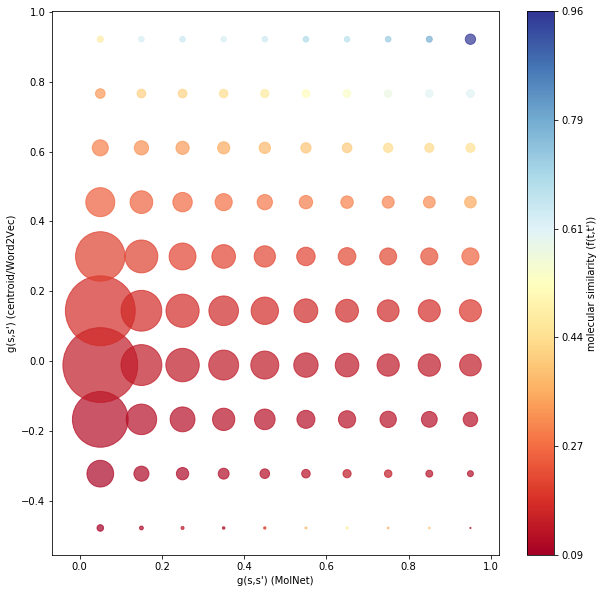

In [215]:
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')

ax.scatter(data_x, data_y, s=100*np.array(data_z)**0.5, c=data_z_mean, cmap=cm, alpha=0.7)
plt.xlabel("g(s,s') (MolNet)")
plt.ylabel("g(s,s') (centroid/Word2Vec)")

# Optionally add a colorbar
max_color = np.max(data_z_mean)
min_color = np.min(data_z_mean)
color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels([x for x in list(color_ticks)])
plt.ylabel("molecular similarity (f(t,t'))")

In [278]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [279]:
data_x = []
data_y = []
data_z = []
for i in range(bins_x):
    data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
#        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
    mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
    data_y.append(mean_mol_score)
    data_z.append(np.sum(H[i,:]))

In [282]:
import seaborn as sns
import pandas as pd


In [287]:
data_df = pd.DataFrame(H, columns = edges[1][:-1], index = edges[0][:-1])

In [306]:
data_df2.head()

centroid  molscore    molnet  bin_x
0  1.000000  1.000000  1.000000     25
1  0.056423  0.283871  0.063293      9
2  0.073871  0.187135  0.004940     10
3 -0.025092  0.083832  0.006946      8
4  0.115509  0.168539  0.208322     10

In [293]:
data_df2 = pd.DataFrame(M_sim_ctr.reshape(9550**2), columns = ['centroid'])

In [295]:
data_df2['molscore'] = tanimoto_similarities.reshape(9550**2)
data_df2['molnet'] = molnet_sim_hung.reshape(9550**2)

In [304]:
min_x, max_x, np.min(bins)

(-0.5561628469642712, 1.0, 0)

In [ ]:
bins_x = 25
min_x = np.min(M_sim_ctr)
max_x = np.max(M_sim_ctr)

bins = ((M_sim_ctr.reshape(9550**2) - min_x)/(max_x- min_x) *bins_x).astype(int)
data_df2['bin_x'] = bins 

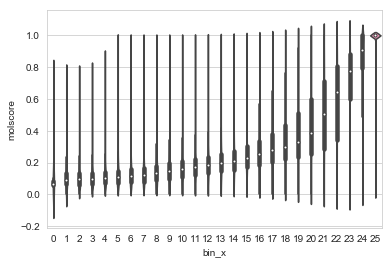

In [309]:
# Set theme
sns.set_style('whitegrid')
 
# Violin plot
sns.violinplot(x = 'bin_x', y = 'molscore', data=data_df2)

In [311]:
plt.savefig("violin_01.png")

<Figure size 432x288 with 0 Axes>

### Violin plots with that amount of data 9500^2 take long! Try bining?

In [312]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [259]:
data_x = []
data_y = []
data_z = []
for i in range(bins_x):
    data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
#        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
    mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
    data_y.append(mean_mol_score)
    data_z.append(np.sum(H[i,:]))

Text(0, 0.5, "molecular similarity (f(t,t'))")

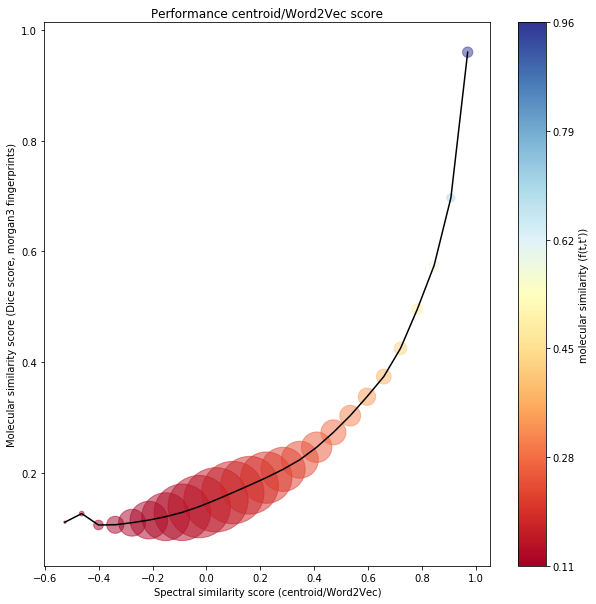

In [257]:
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')

plt.scatter(data_x, data_y, s = np.array(data_z)**0.5, c = data_y, cmap=cm, alpha = 0.5)
plt.plot(data_x, data_y, color='black')
plt.xlabel("Spectral similarity score (centroid/Word2Vec)")
plt.ylabel("Molecular similarity score (Dice score, morgan3 fingerprints)")
plt.title("Performance centroid/Word2Vec score" )

# Optionally add a colorbar
max_color = np.max(data_y)
min_color = np.min(data_y)
color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels([x for x in list(color_ticks)])
plt.ylabel("molecular similarity (f(t,t'))")

### Try faster alternatives for violin plots

In [351]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [352]:
data_x = []
data_y = []
data_z = []
data_y_mean = []
for i in range(bins_x):
    for j in range(bins_y):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
        data_y_mean.append(mean_mol_score)
        data_z.append(np.sum(H[i,j])/np.sum(H[i,:]))

Text(0.5, 1.0, 'Word2Vec vs. molecular similarity')

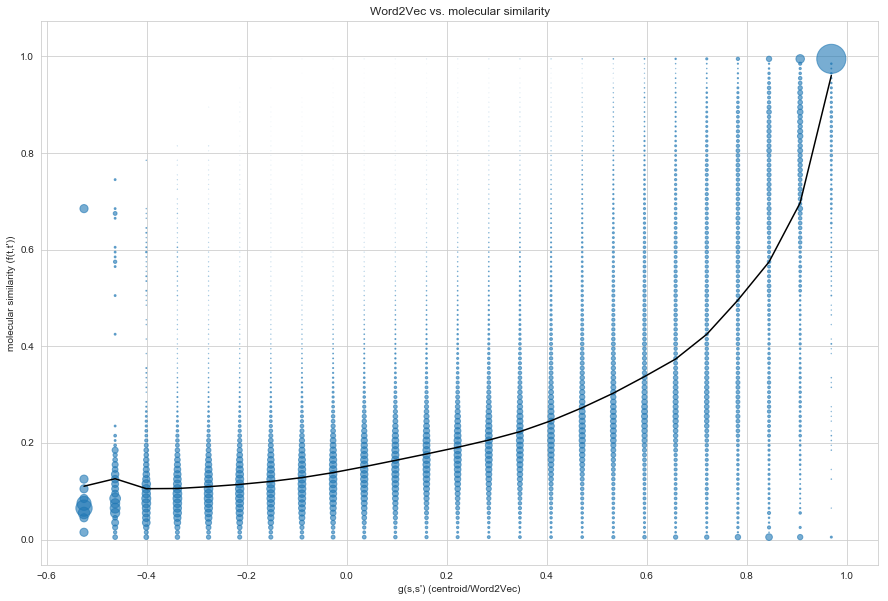

In [353]:
fig, ax = plt.subplots(figsize=(15,10))
cm = plt.cm.get_cmap('RdYlBu')
#100*np.array(data_z)**0.5 c=data_y, 
ax.scatter(data_x, data_y, s=1000*np.array(data_z), cmap=cm, alpha=0.6)
plt.plot(data_x, data_y_mean, color='black')
plt.xlabel("g(s,s') (centroid/Word2Vec)")
plt.ylabel("molecular similarity (f(t,t'))")
plt.title("Word2Vec vs. molecular similarity")

Text(0.5, 1.0, 'Molnet vs. molecular similarity')

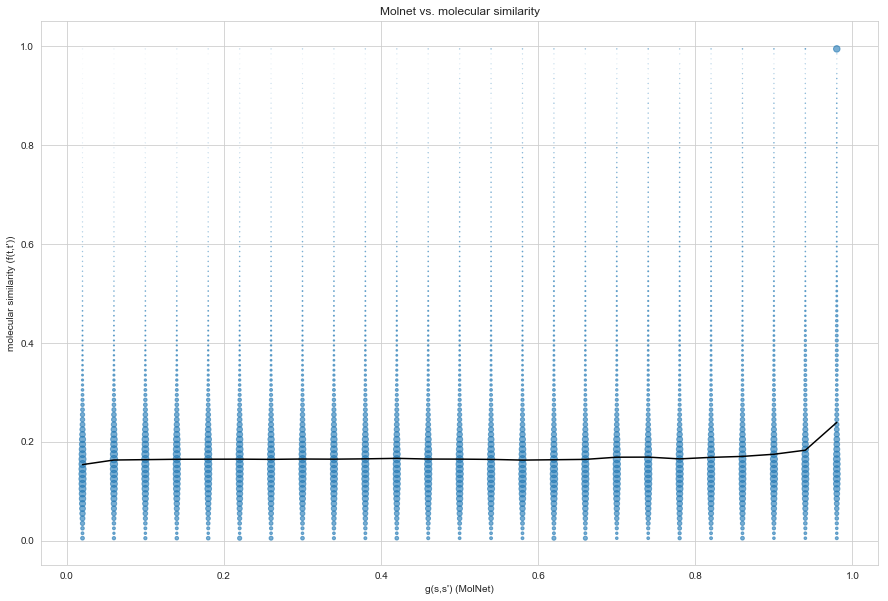

In [349]:
fig, ax = plt.subplots(figsize=(15,10))
cm = plt.cm.get_cmap('RdYlBu')
#100*np.array(data_z)**0.5 c=data_y, 
ax.scatter(data_x, data_y, s=1000*np.array(data_z), cmap=cm, alpha=0.6)
plt.plot(data_x, data_y_mean, color='black')
plt.xlabel("g(s,s') (MolNet)")
plt.ylabel("molecular similarity (f(t,t'))")
plt.title("Molnet vs. molecular similarity")


In [259]:
data_x = []
data_y = []
data_z = []
for i in range(bins_x):
    data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
#        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
    mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
    data_y.append(mean_mol_score)
    data_z.append(np.sum(H[i,:]))

Text(0, 0.5, "molecular similarity (f(t,t'))")

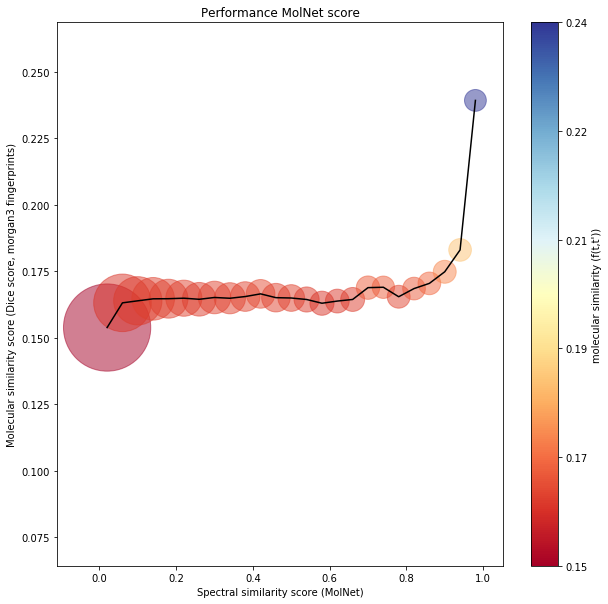

In [260]:
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')

plt.scatter(data_x, data_y, s = np.array(data_z)**0.5, c = data_y, cmap=cm, alpha = 0.5)
plt.plot(data_x, data_y, color='black')
plt.xlabel("Spectral similarity score (MolNet)")
plt.ylabel("Molecular similarity score (Dice score, morgan3 fingerprints)")
plt.title("Performance MolNet score" )

# Optionally add a colorbar
max_color = np.max(data_y)
min_color = np.min(data_y)
color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels([x for x in list(color_ticks)])
plt.ylabel("molecular similarity (f(t,t'))")

In [21]:
idx = np.arange(9550**2) 
                 

### Plot with bins that contain equal number of spectra... (doesn't work well)

In [31]:
Data = np.concatenate((idx.T,
                      tanimoto_similarities.reshape(9550**2).T,
                     M_sim_ctr.reshape(9550**2).T,
                     cosine_sim.reshape(9550**2).T), axis=0)
print(Data.shape)

(364810000,)


In [32]:
Data = np.zeros((4, 9550**2))
Data[0,:] = idx
Data[1,:] = tanimoto_similarities.reshape(9550**2)
Data[2,:] = M_sim_ctr.reshape(9550**2)
Data[3,:] = cosine_sim.reshape(9550**2)
print(Data.shape)

(4, 91202500)


In [38]:
Data = Data[:,np.lexsort((Data[0,:], Data[2,:]))]  # sort by Word2Vec score

In [105]:
A, B = np.histogram(Data[1,:100], bins = 1/10*np.arange(11))
A[1]

26

In [72]:
no_bins_x = 1000
no_bins_y = 50

length = Data.shape[1]
bin_size_x = length/no_bins_x
bins_x = (np.arange(no_bins_x+1)*bin_size_x).astype(int)

#min_ref = np.min(Data[1,:])
max_ref = np.max(Data[1,:])
bins_y = max_ref * 1/no_bins_y*np.arange(no_bins_y+1)

#data_x_mean = np.zeros((no_bins_x))
#data_y = np.zeros((no_bins_x, no_bins_y))
#data_y_mean = np.zeros((no_bins_x))
data_x = []
data_x_mean = []
data_y_mean = []
data_y = []
data_z = []
for i in range(no_bins_x):
    low = bins_x[i]
    high = bins_x[i+1]
    
    x_pos = np.mean(Data[2,low:high])
    y_pos = np.mean(Data[1,low:high])
    data_x_mean.append(x_pos)
    data_y_mean.append(y_pos)
    A, B = np.histogram(Data[1,low:high], bins = bins_y)
    for j in range(no_bins_y):
        data_x.append(x_pos)
        data_y.append(B[j])
        data_z.append(A[j])
        
    

In [74]:
len(data_x_mean)

1000

Text(0, 0.5, "molecular similarity f(t,t')")

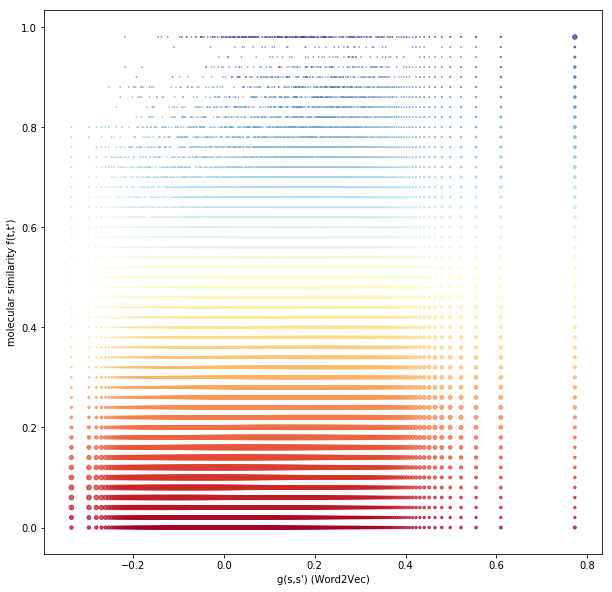

In [73]:
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')

ax.scatter(data_x, data_y, s=0.2*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.7)
plt.xlabel("g(s,s') (Word2Vec)")
plt.ylabel("molecular similarity f(t,t')")

### Plot to compare molecular similarity of closest spectral matches

In [114]:
avg_best_scores, labels = MS_functions.compare_best_results(spectra_dict, 
                                                             spectra,
                                                             MS_measure,
                                                             tanimoto_similarities,
                                                             cosine_sim,
                                                             num_candidates = 25,
                                                             similarity_method = ["centroid"])

In [120]:
avg_best_scores2, labels2 = MS_functions.compare_best_results(spectra_dict, 
                                                             spectra,
                                                             MS_measure,
                                                             tanimoto_similarities,
                                                             molnet_sim_hung,
                                                             num_candidates = 25,
                                                             similarity_method = ["centroid"])

In [126]:
avg_best_scores_all= [avg_best_scores[0], avg_best_scores[1], avg_best_scores2[1], avg_best_scores[2]]

In [122]:
labels = ['Tanimoto (best)', 'Cosine score', 'Modified cosine score', 'Spectrum similarity (centroid)']


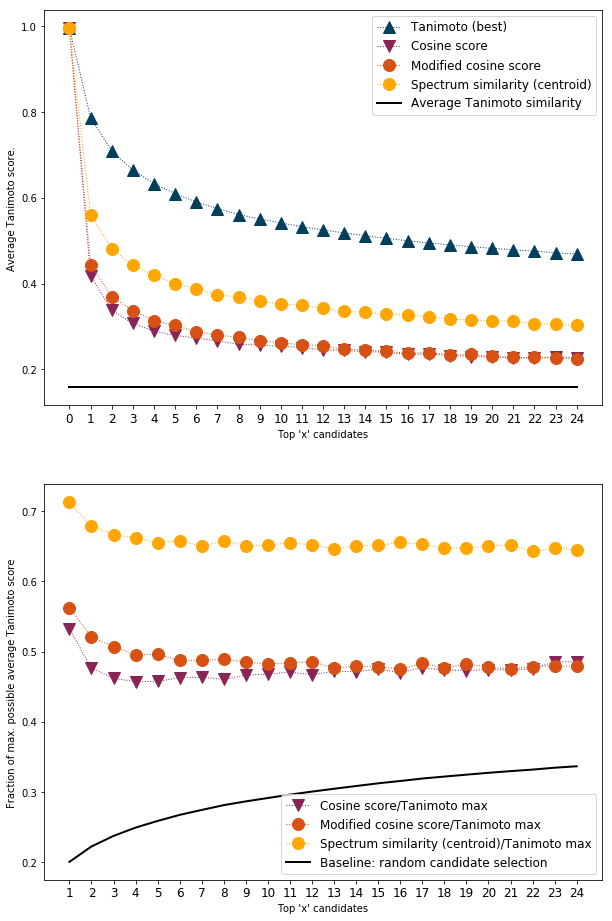

In [127]:
MS_functions.plot_best_results(avg_best_scores_all,  
                              labels,
                              tanimoto_similarities,
                              filename = 'MS_similarity_measures_comparison_test.pdf')

In [128]:
csvfile = PATH_MS_DATA + "ClassyFire_InputforCytoscape_GNPSLibraries.csv"     

import pandas as pd
mol_classes = pd.read_csv(csvfile, delimiter='\t')  

In [129]:
list_mol_superclasses = []
list_mol_classes = []
list_mol_subclasses = []

for spectrum in spectra:
    subtable = mol_classes[mol_classes['inchikey'].str.contains(spectrum.metadata['inchikey'])]
    
    if subtable.shape[0] > 0:  # i.e. if match was found
        list_mol_superclasses.append(subtable['superclass'].values[0])
        list_mol_classes.append(subtable['class'].values[0])
        list_mol_subclasses.append(subtable['subclass'].values[0])
    else:
        list_mol_superclasses.append('None')
        list_mol_classes.append('None')
        list_mol_subclasses.append('None')
    
# Remove nan's
list_mol_superclasses = ['None' if x is np.nan else x for x in list_mol_superclasses]
list_mol_classes = ['None' if x is np.nan else x for x in list_mol_classes]
list_mol_subclasses = ['None' if x is np.nan else x for x in list_mol_subclasses]

### List most similar candidates (and count their properties...)

In [138]:
# Compare word2vec/similarity score
list_similars_ctr_idx = MS_measure.list_similars_ctr_idx
list_similars_ctr = MS_measure.list_similars_ctr

In [246]:
IDs = np.arange(len(spectra))
np.random.choice(IDs, size = 10, replace=False)

array([2731, 6149, 8446, 2494, 7521, 4637, 7934, 5517, 5644,  928])

In [249]:
IDs = np.arange(10)
IDs_new = np.delete(IDs, 5)
IDs_new[1:]

array([1, 2, 3, 4, 6, 7, 8, 9])

In [250]:
num_candidates = 25
cosine_similars_idx = np.zeros((len(spectra), num_candidates))
tanimoto_similars_idx = np.zeros((len(spectra), num_candidates))
random_similars_idx = np.zeros((len(spectra), num_candidates))

IDs = np.arange(len(spectra))

for i in range(len(spectra)):        
    # Compare to molecular networking score
    cosine_candidates = cosine_sim[i,:].argsort()[-num_candidates:][::-1]

    # Compare to maximum possible Tanimoto score
    tanimoto_candidates = tanimoto_similarities[i,:].argsort()[-num_candidates:][::-1] 
    
    # Compare to random choice score
    IDs_new = np.delete(IDs, i)
    random_candidates = np.random.choice(IDs, size = num_candidates-1, replace=False)
    
    cosine_similars_idx[i,:] = cosine_candidates
    tanimoto_similars_idx[i,:] = tanimoto_candidates
    random_similars_idx[i,0] = i
    random_similars_idx[i,1:] = random_candidates

In [251]:
num_links = 10
num_mol_classes_w2v = []
num_mol_classes_cosine = []
num_mol_classes_tanimoto = []
num_mol_classes_random = []
for i in range(len(spectra)):
    candidate_classes = [list_mol_classes[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_classes[x] == "None"]
    num_mol_classes_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in tanimoto_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_tanimoto.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_classes[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_classes[int(x)] == "None"]
    num_mol_classes_random.append(len(set(candidate_classes)))

In [253]:
hist_w2v, _ = np.histogram(num_mol_classes_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_classes_cosine, bins = np.arange(num_links+2))
hist_tanimoto, _ = np.histogram(num_mol_classes_tanimoto, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_classes_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_tanimoto = 100*hist_tanimoto/np.sum(hist_tanimoto)
hist_random = 100*hist_random/np.sum(hist_random)

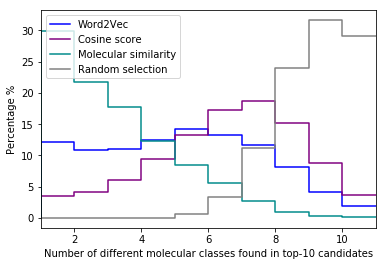

In [255]:
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'blue', label='Word2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score')
plt.step(np.arange(1,num_links+2), hist_tanimoto[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'grey', label='Random selection')
plt.legend()
plt.xlabel('Number of different molecular classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_class.pdf')

In [256]:
num_mol_superclasses_w2v = []
num_mol_superclasses_cosine = []
num_mol_superclasses_tanimoto = []
num_mol_superclasses_random = []
for i in range(len(spectra)):
    candidate_classes = [list_mol_superclasses[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_superclasses[x] == "None"]
    num_mol_superclasses_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_superclasses[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_superclasses[int(x)] for x in tanimoto_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_tanimoto.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_superclasses[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_superclasses[int(x)] == "None"]
    num_mol_superclasses_random.append(len(set(candidate_classes)))

In [257]:
hist_w2v, _ = np.histogram(num_mol_superclasses_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_superclasses_cosine, bins = np.arange(num_links+2))
hist_tanimoto, _ = np.histogram(num_mol_superclasses_tanimoto, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_superclasses_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_tanimoto = 100*hist_tanimoto/np.sum(hist_tanimoto)
hist_random = 100*hist_random/np.sum(hist_random)

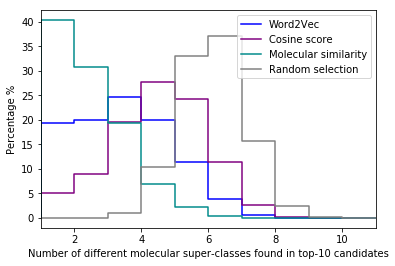

In [258]:
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'blue', label='Word2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score')
plt.step(np.arange(1,num_links+2), hist_tanimoto[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'grey', label='Random selection')
plt.legend()
plt.xlabel('Number of different molecular super-classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_superclass.pdf')

In [260]:
num_mol_subclasses_w2v = []
num_mol_subclasses_cosine = []
num_mol_subclasses_tanimoto = []
num_mol_subclasses_random = []
for i in range(len(spectra)):
    candidate_classes = [list_mol_subclasses[x] for x in list_similars_ctr_idx[i,:num_links+1] if not list_mol_subclasses[x] == "None"]
    num_mol_subclasses_w2v.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in cosine_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_cosine.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in tanimoto_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_tanimoto.append(len(set(candidate_classes)))
    
    candidate_classes = [list_mol_subclasses[int(x)] for x in random_similars_idx[i,:num_links+1] if not list_mol_subclasses[int(x)] == "None"]
    num_mol_subclasses_random.append(len(set(candidate_classes)))

In [261]:
hist_w2v, _ = np.histogram(num_mol_subclasses_w2v, bins = np.arange(num_links+2))
hist_cosine, _ = np.histogram(num_mol_subclasses_cosine, bins = np.arange(num_links+2))
hist_tanimoto, _ = np.histogram(num_mol_subclasses_tanimoto, bins = np.arange(num_links+2))
hist_random, _ = np.histogram(num_mol_subclasses_random, bins = np.arange(num_links+2))

hist_w2v = 100*hist_w2v/np.sum(hist_w2v)
hist_cosine = 100*hist_cosine/np.sum(hist_cosine)
hist_tanimoto = 100*hist_tanimoto/np.sum(hist_tanimoto)
hist_random = 100*hist_random/np.sum(hist_random)

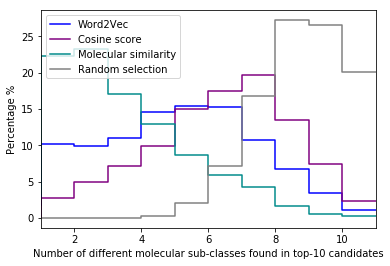

In [262]:
plt.step(np.arange(1,num_links+2), hist_w2v[:], 'blue', label='Word2Vec')
plt.step(np.arange(1,num_links+2), hist_cosine[:], 'purple', label='Cosine score')
plt.step(np.arange(1,num_links+2), hist_tanimoto[:], 'darkcyan', label='Molecular similarity')
plt.step(np.arange(1,num_links+2), hist_random[:], 'grey', label='Random selection')
plt.legend()
plt.xlabel('Number of different molecular sub-classes found in top-10 candidates')
plt.ylabel('Percentage %')
plt.xlim(1,num_links+1)
plt.savefig('comparison_mol_subclass.pdf')

In [264]:
test = np.where((M_sim_ctr - cosine_sim > 0.4) & (M_sim_ctr > 0.85) & (M_sim_ctr < 0.98) & (tanimoto_similarities > 0.8))

2549 1079
0.9055333861129978 0.44709918682958794 1.0
  Created documents for  2  of  2  spectra.

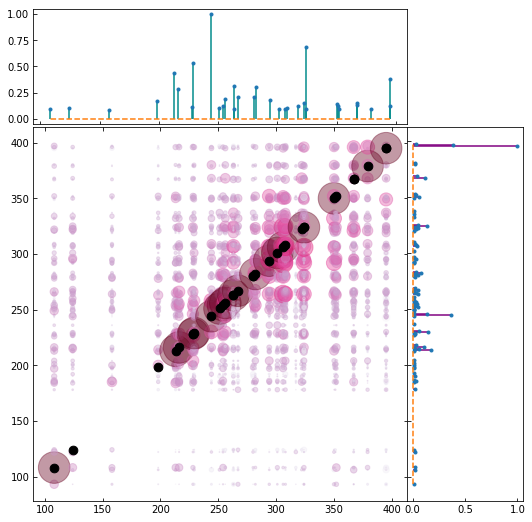

In [265]:
id = 94
ID1, ID2 = test[0][id], test[1][id]
print(ID1, ID2)
print(M_sim_ctr[ID1, ID2], cosine_sim[ID1, ID2], tanimoto_similarities[ID1, ID2])
Cdist_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                   spectra,
                                                   2,
                                                  ID1, ID2, #283,1309, #50, 8878,
                                                 min_mz = 0, 
                                                 max_mz = 1000,
                                                 threshold = 0.01)

### Plot with more (equal sized) bins along X  and y axis...

In [90]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [9]:
def binned_scatter_plot(bins_x, bins_y, H, edges):
    data_x = []
    data_y = []
    data_z = []
    data_y_mean = []
    for i in range(bins_x):
        for j in range(bins_y):
            data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
            data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
            mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
            data_y_mean.append(mean_mol_score)
            data_z.append(np.sum(H[i,j]))#/np.sum(H[i,:]))
            
    fig, ax = plt.subplots(figsize=(15,10))
    cm = plt.cm.get_cmap('viridis')
    #100*np.array(data_z)**0.5 c=data_y, 
    ax.scatter(data_x, data_y, s=1*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.6)
    plt.plot(data_x, data_y_mean, color='black')
    plt.xlabel("g(s,s') (Word2Vec)")
    plt.ylabel("molecular similarity (f(t,t'))")

    # Optionally add a colorbar
    max_color = np.max(data_y)
    min_color = np.min(data_y)
    color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.ax.set_yticklabels([x for x in list(color_ticks)])
    plt.ylabel("molecular similarity (f(t,t'))")

Text(0, 0.5, "molecular similarity (f(t,t'))")

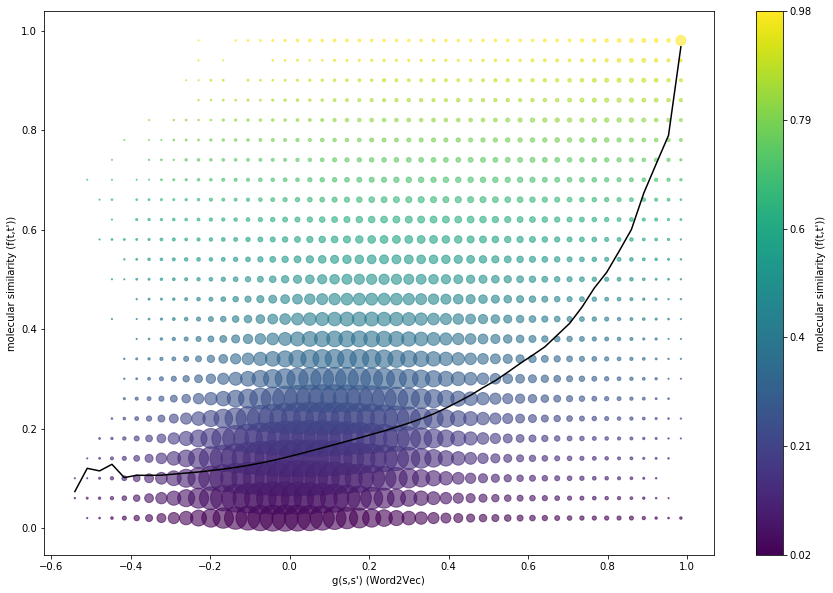

In [96]:
binned_scatter_plot(bins_x, bins_y, H, edges)

In [275]:
bins_xy = 10
bins_z = 100

H, edges = np.histogramdd([cosine_sim.reshape(9550**2), 
                           M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_xy, bins_xy, bins_z))

In [76]:
data_x = []
data_y = []
data_z = []
data_z_mean = []
for i in range(bins_xy):
    for j in range(bins_xy):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        data_z.append(np.sum(H[i,j,:])/10000)
        mean_mol_score = np.sum(H[i,j,:]*(edges[2][:bins_z] + edges[2][1]/2))/(np.sum(H[i,j,:]))
        data_z_mean.append(mean_mol_score)

NameError: name 'bins_xy' is not defined

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0, 0.5, "molecular similarity (f(t,t'))")

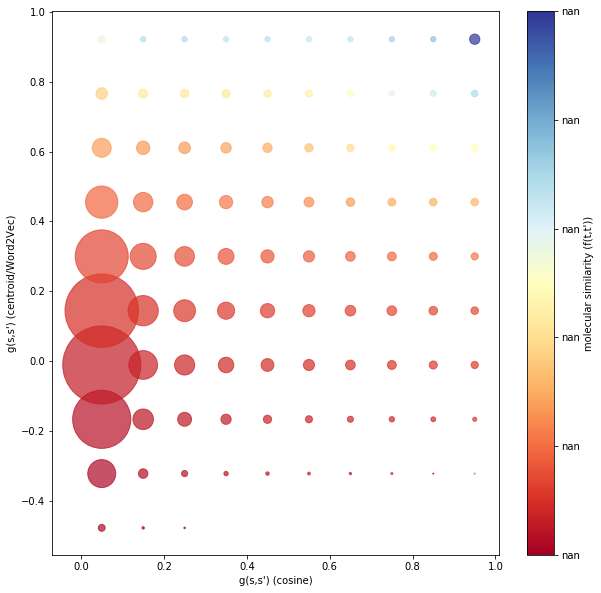

In [277]:
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')

ax.scatter(data_x, data_y, s=100*np.array(data_z)**0.5, c=data_z_mean, cmap=cm, alpha=0.7)
plt.xlabel("g(s,s') (cosine)")
plt.ylabel("g(s,s') (centroid/Word2Vec)")

# Optionally add a colorbar
max_color = np.max(data_z_mean)
min_color = np.min(data_z_mean)
color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels([x for x in list(color_ticks)])
plt.ylabel("molecular similarity (f(t,t'))")

### Compare to 'normal' cosine score (without shift)

In [14]:
def compare_scores(score1, score2, bins_x, bins_y, title, xlabel, ylabel):
    # TODO: check if matrix sizes are correct...
    
    score_matrix_size = score1.shape[0]
    
    H, edges = np.histogramdd([score1.reshape(score_matrix_size**2), 
                               score2.reshape(score_matrix_size**2)], 
                              bins = (bins_x, bins_y))
    
    data_x = []
    data_y = []
    data_z = []
    for i in range(bins_x):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
        data_y.append(mean_mol_score)
        data_z.append(np.sum(H[i,:]))
        
    # Plot results
    fig, ax = plt.subplots(figsize=(10,10))
    cm = plt.cm.get_cmap('RdYlBu')

    plt.scatter(data_x, data_y, s = np.array(data_z)**0.5, c = data_y, cmap=cm, alpha = 0.5)
    plt.plot(data_x, data_y, color='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title )

    # Optionally add a colorbar
    max_color = np.max(data_y)
    min_color = np.min(data_y)
    color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.ax.set_yticklabels([x for x in list(color_ticks)])
    plt.ylabel("molecular similarity (f(t,t'))")

In [12]:
#cosine_sim = MS_functions.cosine_matrix_fast(spectra,
#                                           tol = 0.1,
#                                           max_mz = 1000, 
#                                           min_mz = 0)

filename = PATH_SAVE_DATA + "cosine_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_tol01_minmatch1_minintens001_fast.npy"
cosine_sim = np.load(filename)

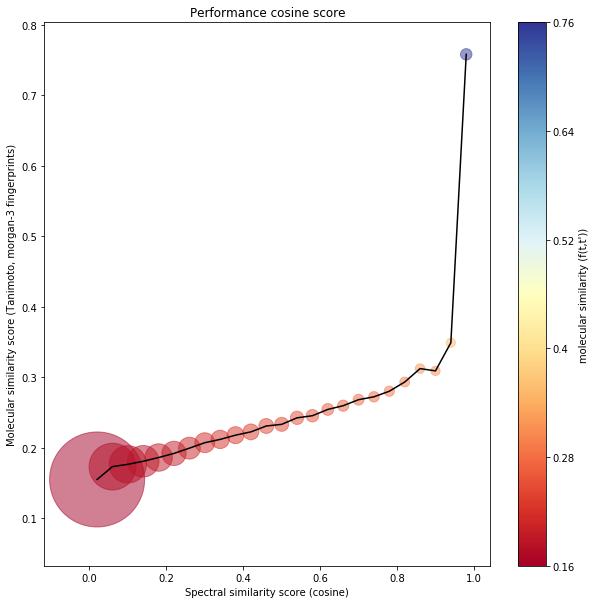

In [18]:
import matplotlib
compare_scores(score1 = cosine_sim, 
               score2 = tanimoto_similarities,
               bins_x = 25, 
               bins_y = 100,
               xlabel = "Spectral similarity score (cosine)",
                ylabel = "Molecular similarity score (Tanimoto, morgan-3 fingerprints)",
                title = "Performance cosine score")

Set similarity threshold to:  0.9470330109055028


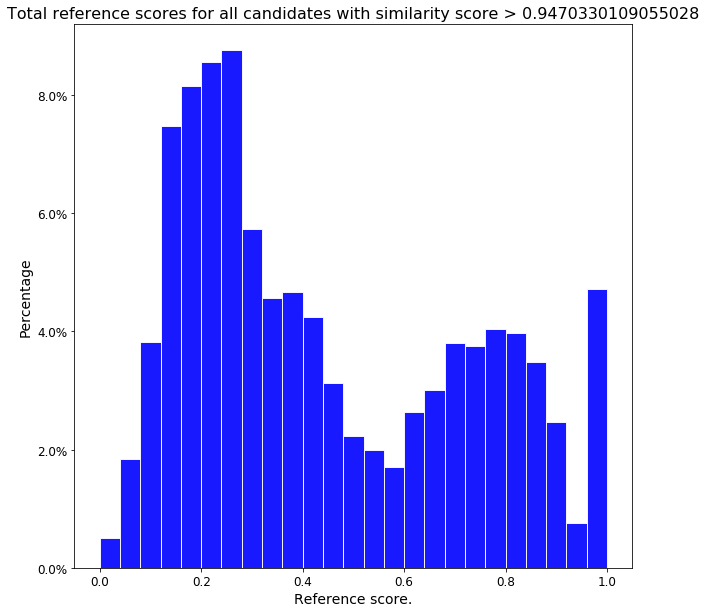

Percentage of highly similar molecules within selection:  38.57 %


In [19]:
num_best = 10000
threshold = np.sort(cosine_sim.reshape(cosine_sim.shape[0]**2))[-(num_best + cosine_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(cosine_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

In [339]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([cosine_sim.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [340]:
data_x = []
data_y = []
data_z = []
data_y_mean = []
for i in range(bins_x):
    for j in range(bins_y):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
        data_y_mean.append(mean_mol_score)
        data_z.append(np.sum(H[i,j])/np.sum(H[i,:]))

Text(0, 0.5, "molecular similarity (f(t,t'))")

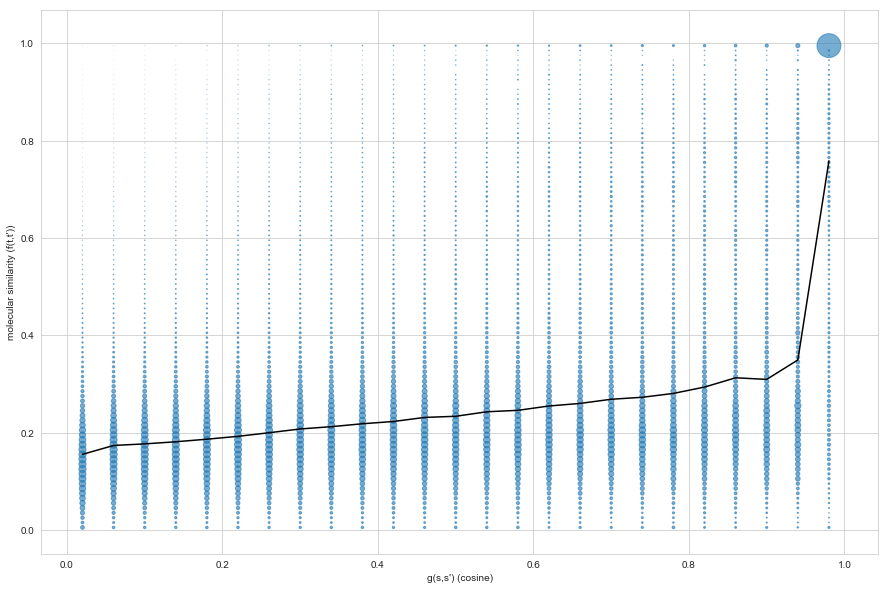

In [341]:
fig, ax = plt.subplots(figsize=(15,10))
cm = plt.cm.get_cmap('RdYlBu')
#100*np.array(data_z)**0.5 c=data_y, 
ax.scatter(data_x, data_y, s=1000*np.array(data_z), cmap=cm, alpha=0.6)
plt.plot(data_x, data_y_mean, color='black')
plt.xlabel("g(s,s') (cosine)")
plt.ylabel("molecular similarity (f(t,t'))")


### Compare different molecular fingerprints

In [262]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_day, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "daylight")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

In [263]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2.npy"
tanimoto_similarities_daylight = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints_day,
                                                      filename = filename)

Tanimoto similarity scores found and loaded.


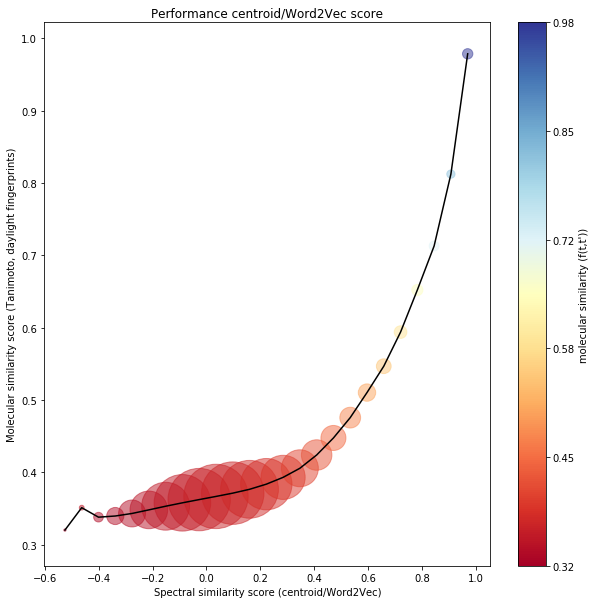

In [270]:
compare_scores(score1 = M_sim_ctr, 
               score2 = tanimoto_similarities_daylight,
               bins_x = 25, 
               bins_y = 100,
               xlabel = "Spectral similarity score (centroid/Word2Vec)",
                ylabel = "Molecular similarity score (Tanimoto, daylight fingerprints)",
                title = "Performance centroid/Word2Vec score")

### Compare to modified cosine score

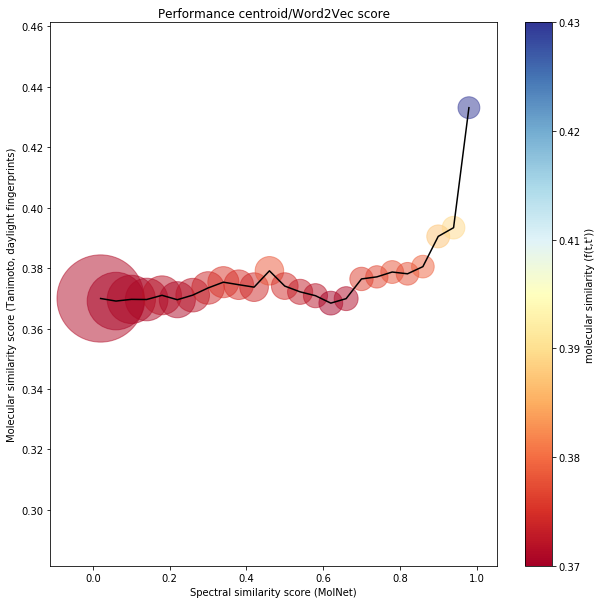

In [271]:
compare_scores(score1 = molnet_sim_hung, 
               score2 = tanimoto_similarities_daylight,
               bins_x = 25, 
               bins_y = 100,
               xlabel = "Spectral similarity score (MolNet)",
                ylabel = "Molecular similarity score (Tanimoto, daylight fingerprints)",
                title = "Performance MolNet score")

In [102]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([molnet_sim_hung.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [103]:
data_x = []
data_y = []
data_z = []
data_y_mean = []
for i in range(bins_x):
    for j in range(bins_y):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
        data_y_mean.append(mean_mol_score)
        data_z.append(np.sum(H[i,j]))#/np.sum(H[i,:]))

Text(0, 0.5, "molecular similarity (f(t,t'))")

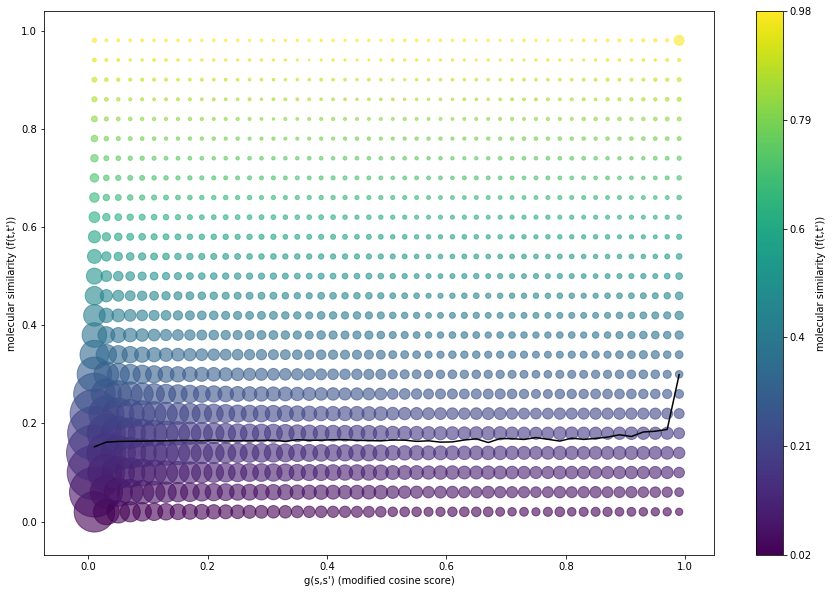

In [104]:
fig, ax = plt.subplots(figsize=(15,10))
cm = plt.cm.get_cmap('viridis')
#100*np.array(data_z)**0.5 c=data_y, 
ax.scatter(data_x, data_y, s=1*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.6)
plt.plot(data_x, data_y_mean, color='black')
plt.xlabel("g(s,s') (modified cosine score)")
plt.ylabel("molecular similarity (f(t,t'))")

# Optionally add a colorbar
max_color = np.max(data_y)
min_color = np.min(data_y)
color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels([x for x in list(color_ticks)])
plt.ylabel("molecular similarity (f(t,t'))")

### Compare to 'normal' cosine score (without shift)

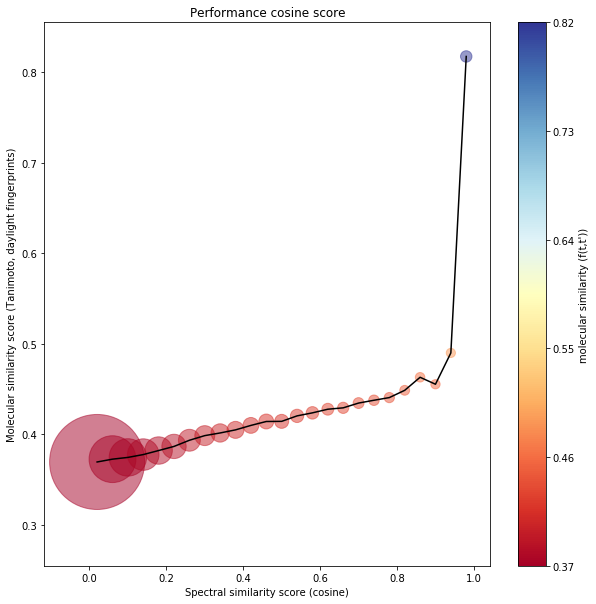

In [273]:
compare_scores(score1 = cosine_sim, 
               score2 = tanimoto_similarities_daylight,
               bins_x = 25, 
               bins_y = 100,
               xlabel = "Spectral similarity score (cosine)",
                ylabel = "Molecular similarity score (Tanimoto, daylight fingerprints)",
                title = "Performance cosine score")

### Compare with Cosine score (tol = 0.05)

In [10]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([cosine_sim005.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

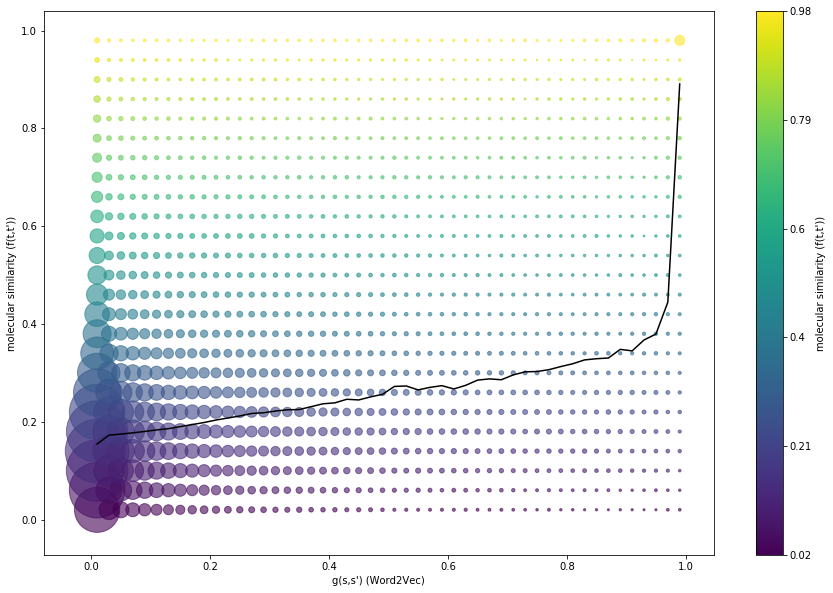

In [14]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.9165122940972792


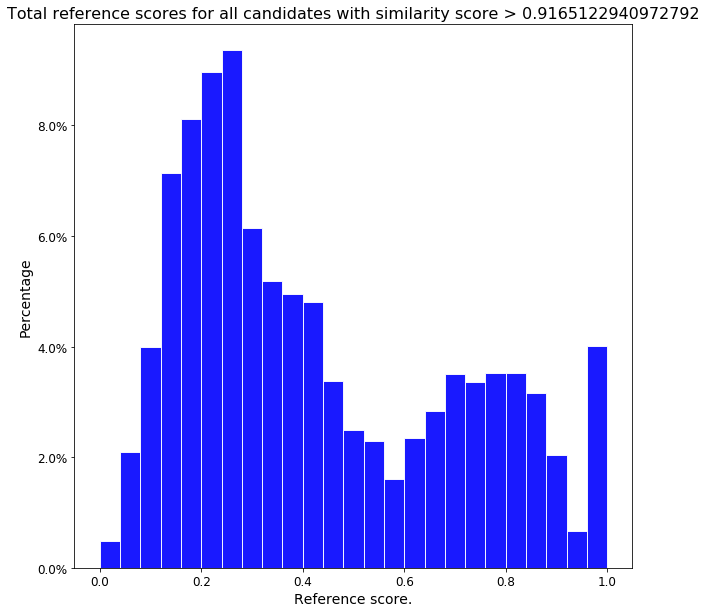

Percentage of highly similar molecules within selection:  35.37 %


In [17]:
num_best = 10000
threshold = np.sort(cosine_sim005.reshape(cosine_sim005.shape[0]**2))[-(num_best + cosine005_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(cosine_sim005, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Compare with Cosine score (tol = 0.1)

Text(0, 0.5, "molecular similarity (f(t,t'))")

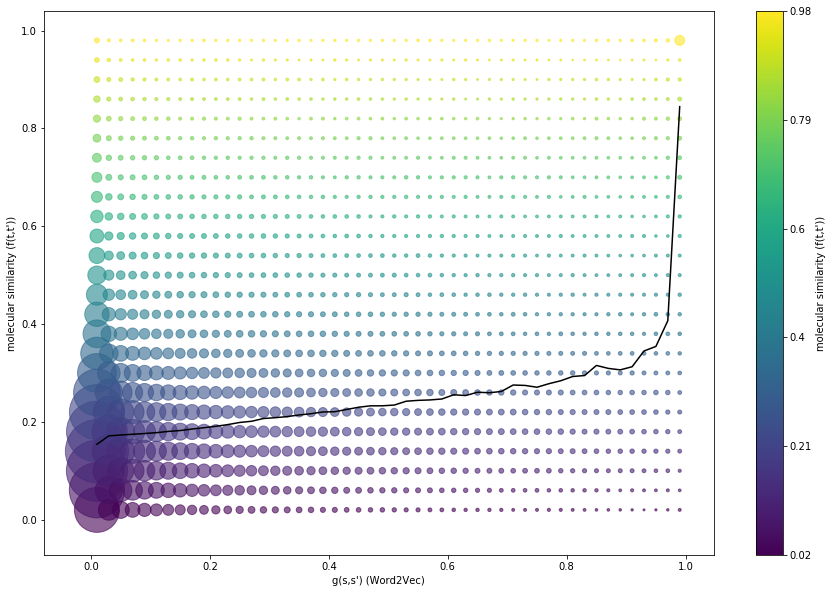

In [99]:
binned_scatter_plot(bins_x, bins_y, H, edges)

### Compare to other similarity measures:

## LDA

In [21]:
file_model_lda =  PATH_SAVE_MODEL + 'model_lda_MS_uniquesmiles_topic200_loss500_dec2.model' 
MS_measure.build_model_lda(file_model_lda, num_of_topics=200, num_pass=4, 
                        num_iter=100, use_stored_model=True)

Load stored LDA model ...


In [22]:
MS_measure.get_lda_similarity(num_hits=25)

In [26]:
import gensim 
from gensim.test.utils import get_tmpfile
index_tmpfile = get_tmpfile("index")
index = gensim.similarities.Similarity(index_tmpfile, MS_measure.model_lda[MS_measure.bow_corpus], 
                                       num_features=len(MS_measure.dictionary))  # build the index
M_sim = np.zeros((len(MS_measure.corpus), len(MS_measure.corpus)))
for i, similarities in enumerate(index):  # yield similarities of all indexed documents
    M_sim[:,i] = similarities

Set similarity threshold to:  0.6641027927398682


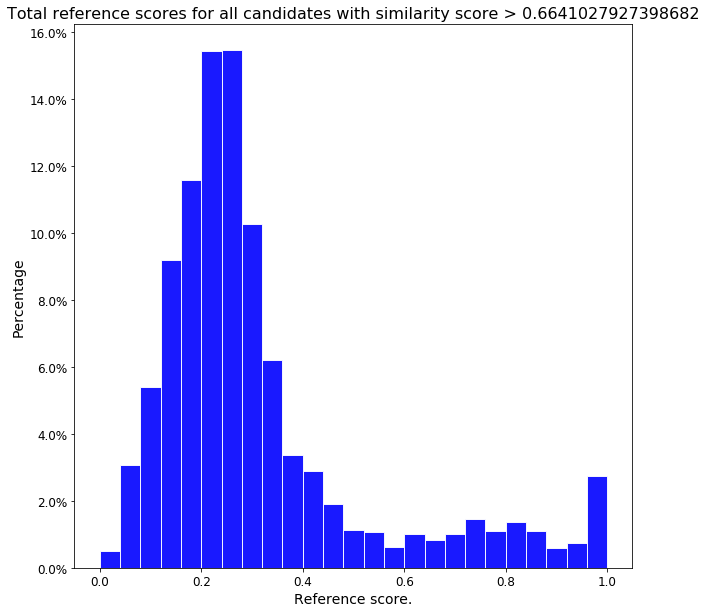

Percentage of highly similar molecules within selection:  14.72 %


In [27]:
num_best = 10000
threshold = np.sort(M_sim.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_lda.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

## LSI

In [20]:
file_model_lsi =  PATH_SAVE_MODEL + 'model_lsi_MS_uniquesmiles_topic300_iter20_loss500_dec2.model' 
MS_measure.build_model_lsi(file_model_lsi, num_of_topics=300, num_iter=20, use_stored_model=True)

Load stored LSI model ...


In [21]:
MS_measure.get_lsi_similarity(num_hits=25)

In [23]:
import gensim 
from gensim.test.utils import get_tmpfile
index_tmpfile = get_tmpfile("index")
index = gensim.similarities.Similarity(index_tmpfile, MS_measure.model_lsi[MS_measure.bow_corpus], 
                                       num_features=len(MS_measure.dictionary))  # build the index
M_sim_lsi = np.zeros((len(MS_measure.corpus), len(MS_measure.corpus)))
for i, similarities in enumerate(index):  # yield similarities of all indexed documents
    M_sim_lsi[:,i] = similarities

In [60]:
print(M_sim_lsi[:10,:10])

[[ 0.99999976  0.24683714  0.10210143  0.02026386  0.09987143 -0.00874199
   0.0755726   0.10318945  0.01997916  0.11776125]
 [ 0.24683714  0.99999964  0.30029091  0.07281049  0.16676907  0.16255526
   0.15694375  0.1459273   0.13910472  0.15488034]
 [ 0.10210143  0.30029091  0.99999982  0.23714505  0.13738906  0.22243787
   0.16508731  0.1247952   0.09515084  0.08775873]
 [ 0.02026386  0.07281049  0.23714505  1.00000024  0.30992481  0.29913828
   0.11534653  0.09305678  0.05892274  0.1255189 ]
 [ 0.09987143  0.16676907  0.13738906  0.30992481  0.99999982  0.25611559
   0.09918535  0.10797343  0.12047406  0.10059546]
 [-0.00874199  0.16255526  0.22243787  0.29913828  0.25611559  1.00000048
   0.23527184  0.08326226  0.17453124  0.10188346]
 [ 0.0755726   0.15694375  0.16508731  0.11534653  0.09918535  0.23527184
   1.00000024  0.25638512  0.15085153  0.12101997]
 [ 0.10318945  0.1459273   0.1247952   0.09305678  0.10797343  0.08326226
   0.25638512  1.00000012  0.24479812  0.12051262]


Set similarity threshold to:  0.669819712638855


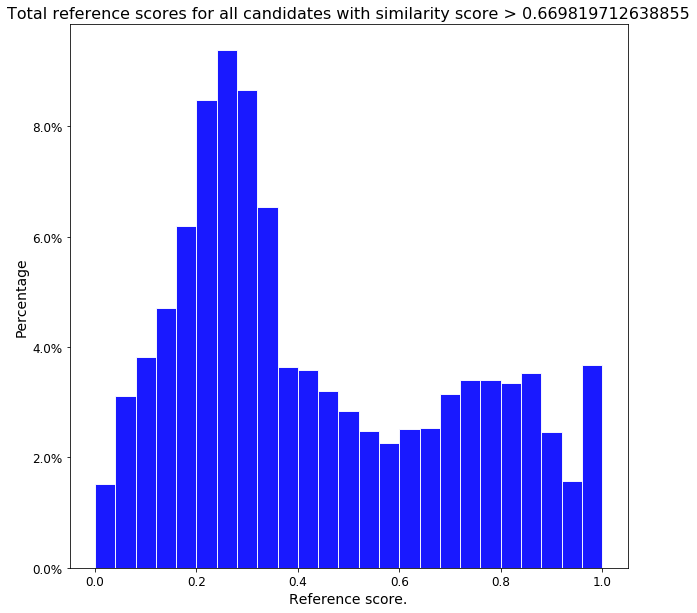

Percentage of highly similar molecules within selection:  37.2 %


In [24]:
num_best = 10000
threshold = np.sort(M_sim_lsi.reshape(M_sim_lsi.shape[0]**2))[-(num_best + M_sim_lsi.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_lsi, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_lda.png")

print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

## GloVe

In [11]:
file_model_glove = PATH_SAVE_MODEL + 'model_glove_MS_uniquesmiles_d300_w300_iter10_loss500_minpeak10_dec2.model'
MS_measure.build_model_glove(file_model_glove, vector_size=300, window=300, 
                             learning_rate=0.05, workers=8, epochs=10, 
                             use_stored_model=True)

Load stored GloVe model ...


In [12]:
# Use peak intensities as extra weights
MS_measure.get_vectors_glove(extra_weights = MS_documents_intensity, tfidf_weighted=True)
MS_measure.get_glove_similarity(num_hits=25, method='cosine')

  Calculated GloVe vectors for  9550  of  9550  documents.Calculated GloVe vectors for  620  of  9550  documents. documents. Calculated GloVe vectors for  1990  of  9550  documents. 2070  of  9550  documents.2230  of  9550  documents.2790  of  9550  documents. Calculated GloVe vectors for  3940  of  9550  documents. of  9550  documents. Calculated GloVe vectors for  7120  of  9550  documents. Calculated GloVe vectors for  8490  of  9550  documents. Calculated GloVe vectors for  8680  of  9550  documents. 9090  of  9550  documents.Calculated distances between  9550  documents.


In [14]:
from scipy import spatial
M_sim = 1 - spatial.distance.cdist(MS_measure.vectors_glove, MS_measure.vectors_glove, 'cosine')

Set similarity threshold to:  0.9713280472075719


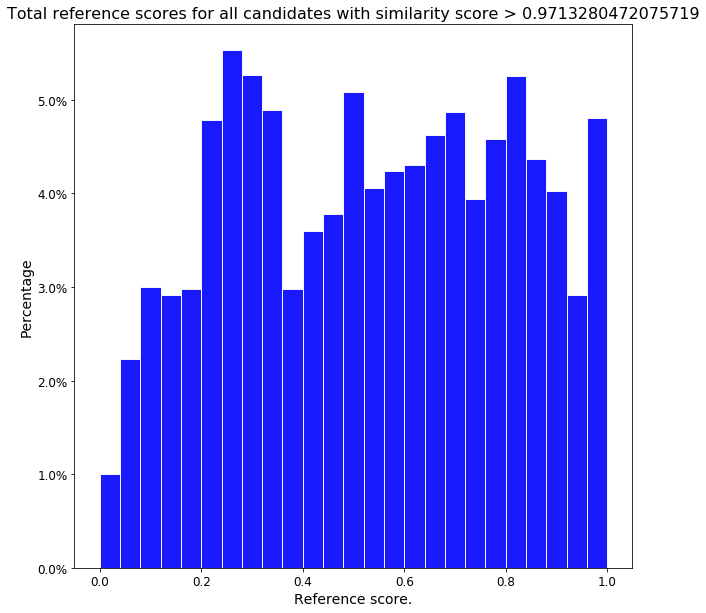

Percentage of highly similar molecules within selection:  57.06 %


In [15]:
num_best = 10000
threshold = np.sort(M_sim.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_glove.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

In [17]:
# Compare to case without using intensities as extra weights
MS_measure.get_vectors_glove(extra_weights = None, tfidf_weighted=True)
MS_measure.get_glove_similarity(num_hits=25, method='cosine')

  Calculated GloVe vectors for  9550  of  9550  documents.  of  9550  documents.Calculated distances between  9550  documents.


In [18]:
from scipy import spatial
M_sim = 1 - spatial.distance.cdist(MS_measure.vectors_glove, MS_measure.vectors_glove, 'cosine')

Set similarity threshold to:  0.9709511323748968


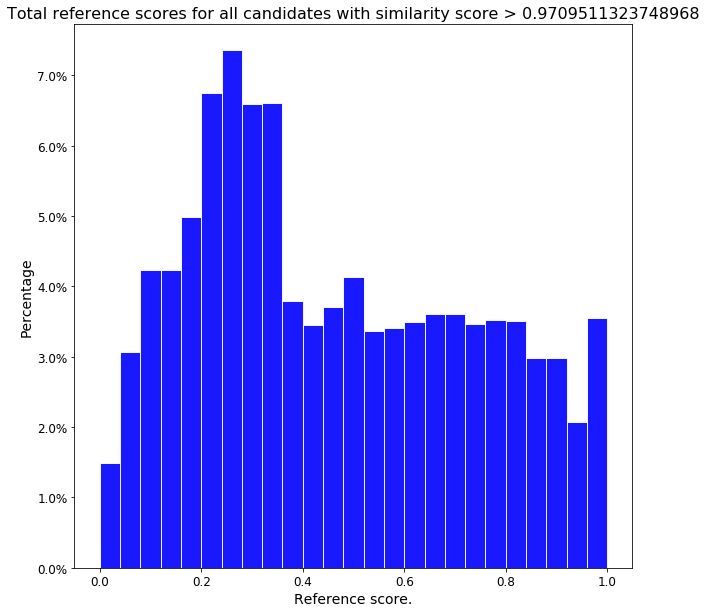

Percentage of highly similar molecules within selection:  43.72 %


In [19]:
num_best = 10000
threshold = np.sort(M_sim.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_glove2.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

## Consider combined scores as well

Set similarity threshold to:  0.4646899778400136


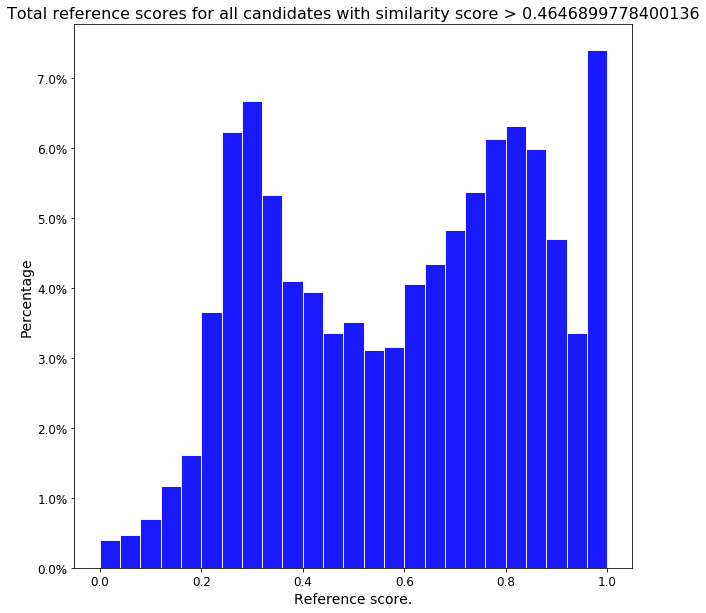

Percentage of highly similar molecules within selection:  62.33 %


In [25]:
num_best = 10000
M_combine = M_sim_ctr * M_sim_lsi
threshold = np.sort(M_combine.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_combine, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_combine.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

Set similarity threshold to:  0.6694727948551927


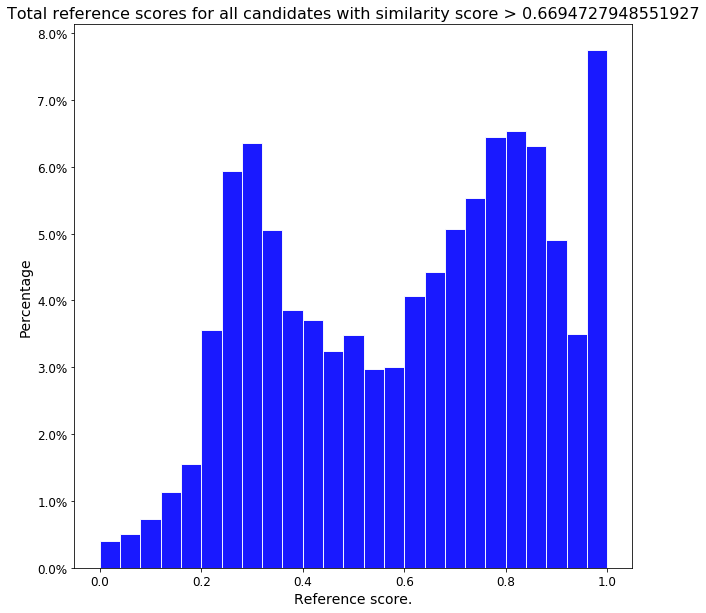

Percentage of highly similar molecules within selection:  63.99 %


In [27]:
num_best = 10000
M_combine = M_sim_ctr * M_sim_lsi + 0.2 * M_sim_ctr + 0.08 * M_sim_lsi
threshold = np.sort(M_combine.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_combine, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_combine2.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

Set similarity threshold to:  0.8247826153957303


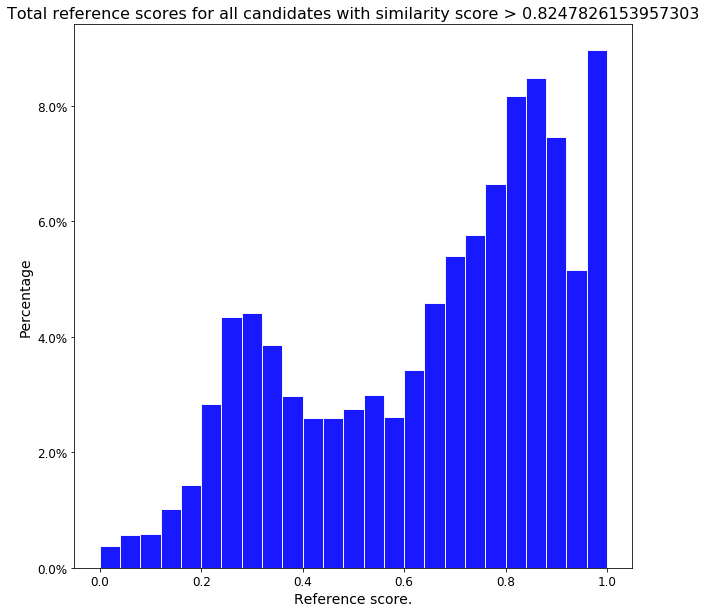

Percentage of highly similar molecules within selection:  72.41 %


In [32]:
num_best = 10000
M_combine = 0.55 * M_sim_ctr  + 0.1 * M_sim_lsi + 0.35 * M_sim
threshold = np.sort(M_combine.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_combine, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_combine3.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### So far, doesn't seem to perform better than word2vec alone!
(using this type of benchmarking measure)

Set similarity threshold to:  0.8633877063117205


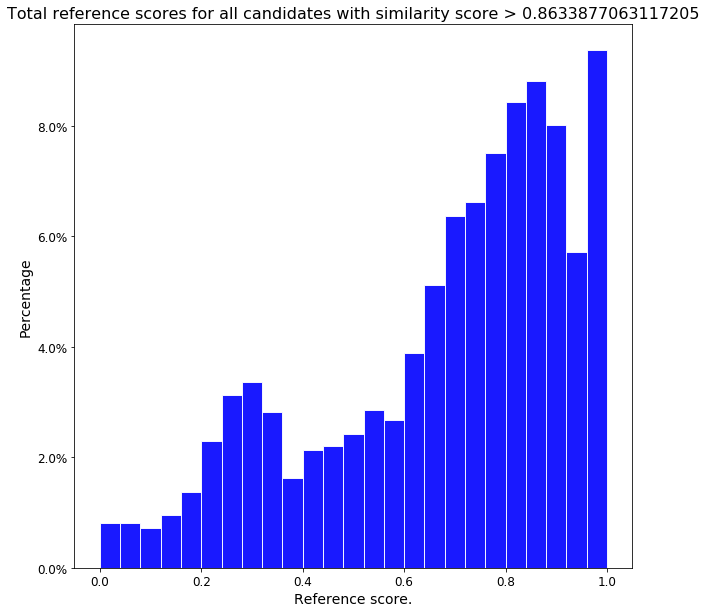

Percentage of highly similar molecules within selection:  77.77 %


In [41]:
num_best = 10000
M_combine = M_sim_ctr * (M_sim_ctr>0.5) + M_sim_lsi * (M_sim_lsi > 0.7)
threshold = np.sort(M_combine.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_combine, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_combine.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Note: Comparing different molecular fingerprints!
Technically, Tanimoto is not the right naming here!
For the rdkit default fingerprints (**Daylight**) I here indeed used Tanimoto similarity to compare fingerprints. 

But for the morgen-3 or **ECFP-6** finterprints it is actually a Dice score!

In [12]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'molecular similarity (daylight fingerprint)')

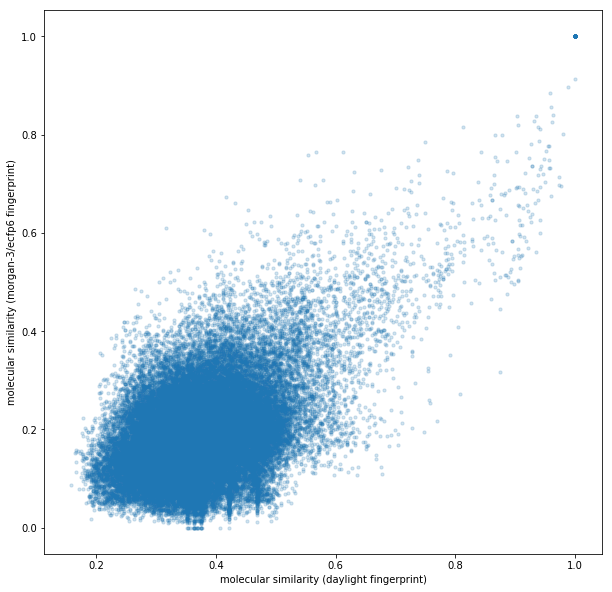

In [233]:
# Agreement between daylight and morgan-3/ecfp6 fingerprint-based molecular similarity.
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_daylight[:300,:300], tanimoto_similarities[:300,:300], s=10, alpha=0.1)
plt.ylabel("molecular similarity (morgan-3/ecfp6 fingerprint)")
plt.xlabel("molecular similarity (daylight fingerprint)")

#### Compare morgan-3 scores (Dice score) with word2vec/centroid scores

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

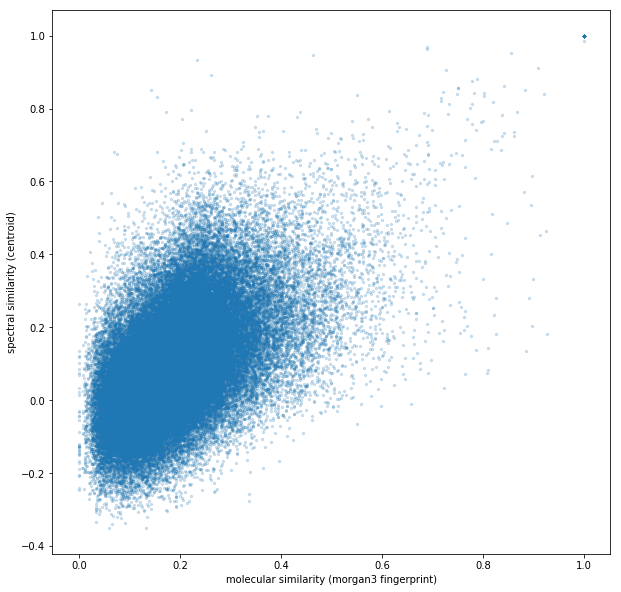

In [36]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities[:400,:400], M_sim_ctr[:400,:400], s=5, alpha=0.1)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

### Zoom in to high similarity values

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

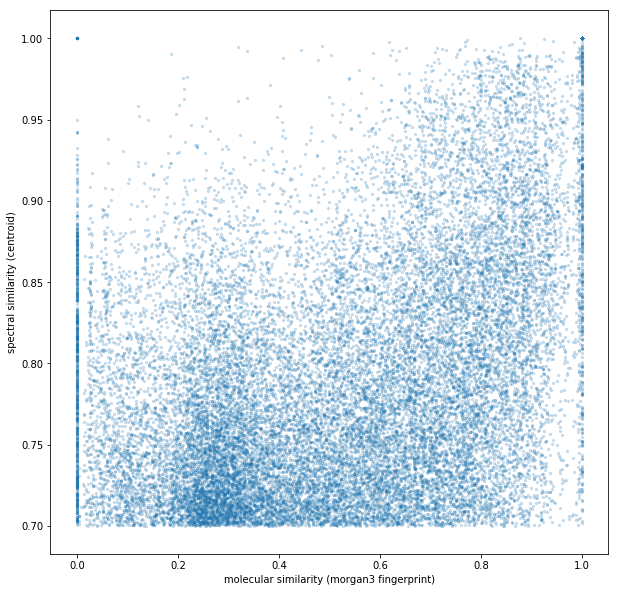

In [38]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
#select = np.where(tanimoto_similarities_m3 > 0.6)
select = np.where(M_sim_ctr > 0.7)
ax.scatter(tanimoto_similarities[select], M_sim_ctr[select], s=5, alpha=0.1)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0, 0.5, 'spectral similarity (LSI)')

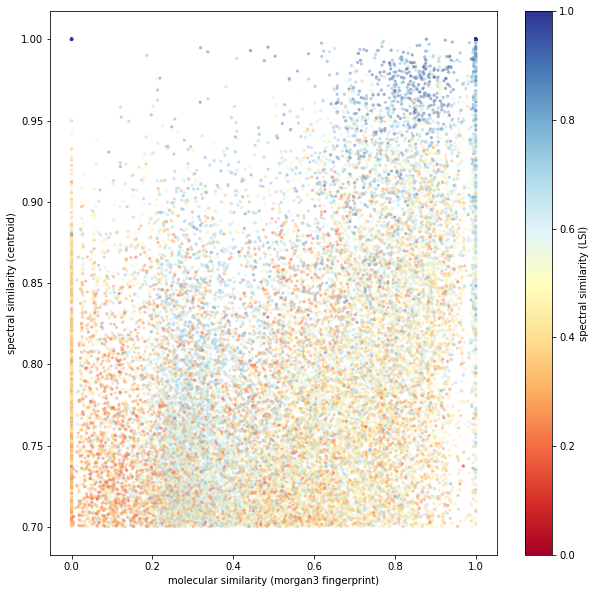

In [63]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid) and LSI scores
select = np.where(M_sim_ctr > 0.7)

import matplotlib
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')
ax.scatter(tanimoto_similarities[select], M_sim_ctr[select], s=5, c=M_sim_lsi[select], cmap=cm, alpha=0.2)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm)
plt.ylabel("spectral similarity (LSI)")

### Compare molecular similarity scores with Mol.Net scoring

Text(0.5, 0, 'molecular similarity (morgan-3 fingerprint)')

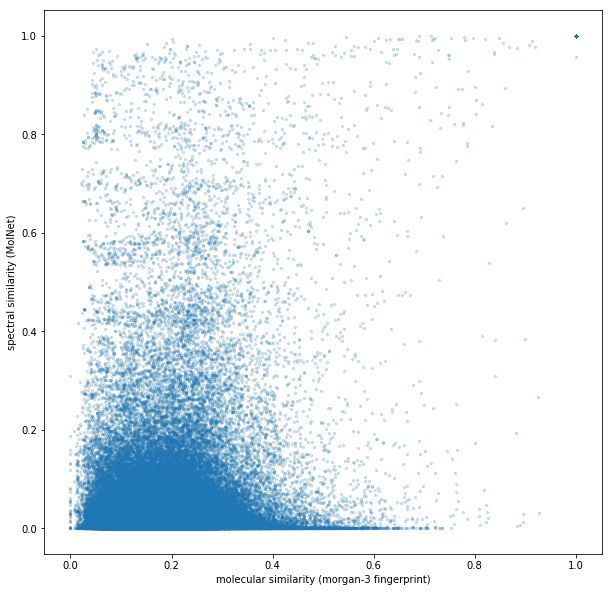

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities[:400,:400], molnet_sim[:400,:400], s=5, alpha=0.1)
plt.ylabel("spectral similarity (MolNet)")
plt.xlabel("molecular similarity (morgan-3 fingerprint)")

#### Compare morgan-3 scores (Dice score) with LSI scores

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

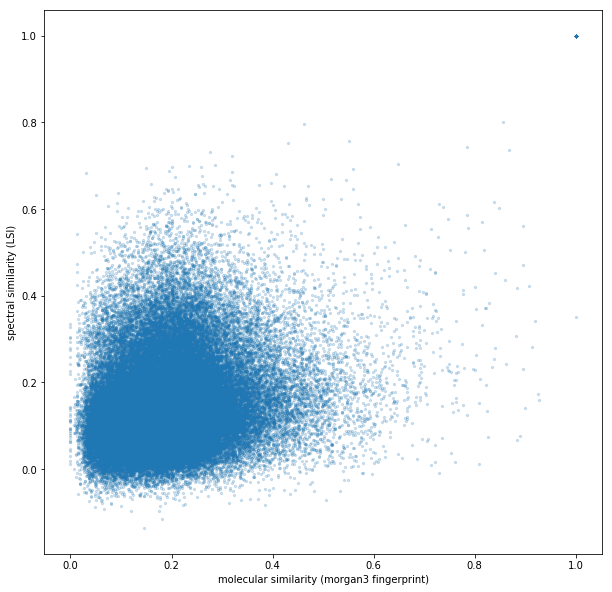

In [64]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities[:400,:400], M_sim_lsi[:400,:400], s=5, alpha=0.1)
plt.ylabel("spectral similarity (LSI)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

In [65]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_day, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "daylight")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Problem with molecule 7452
Problem with molecule 7522
Problem with molecule 7612
Problem with molecule 13527
Problem with molecule 13771
Problem with molecule 14111
Problem with molecule 14429
Problem with molecule 14652
Problem with molecule 15085
Problem with molecule 15140
Problem with molecule 15175
Problem with molecule 15531
Problem with molecule 15810
Problem with molecule 15981
Problem with molecule 15997
Problem with molecule 16095
Problem with molecule 16129
Problem with molecule 16151
Problem with molecule 16160
Problem with molecule 16163
Problem with molecule 16706
Problem with molecule 16707
Problem with molecule 16708
Problem with molecule 16709
Problem with molecule 16710
Problem with molecule 16711
Problem with molecule 16885
Problem with molecule 16981
Problem with molecule 17119
Problem with molecule 35001
Problem with molecule 35006
Problem with molecule 35008
Problem with molecule 35009
Problem with molecule 35013
Problem with molecule 35

## Compare to  'daylight' molecular fingerprints.  
Tanimoto score on daylight-like molecular fingerprints (rdkit).

In [66]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2.npy"
tanimoto_similarities_daylight = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints_day,
                                                      filename = filename)

Tanimoto similarity scores found and loaded.


Text(0.5, 0, 'molecular similarity (daylight fingerprint)')

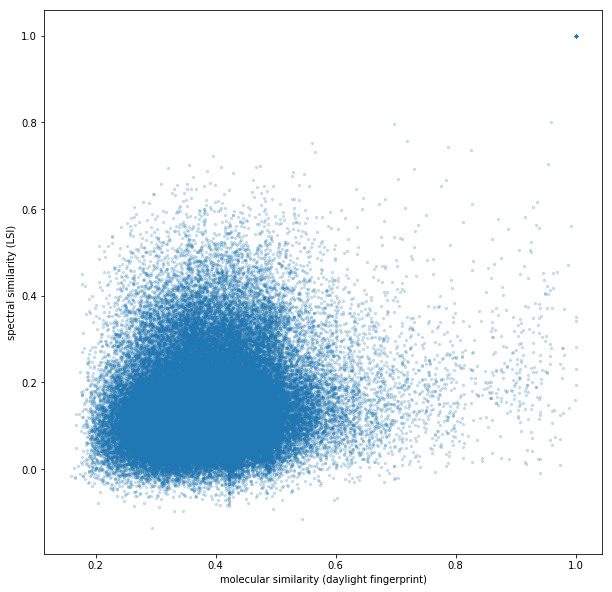

In [67]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_daylight[:400,:400], M_sim_lsi[:400,:400], s=5, alpha=0.1)
plt.ylabel("spectral similarity (LSI)")
plt.xlabel("molecular similarity (daylight fingerprint)")

Set similarity threshold to:  0.669819712638855


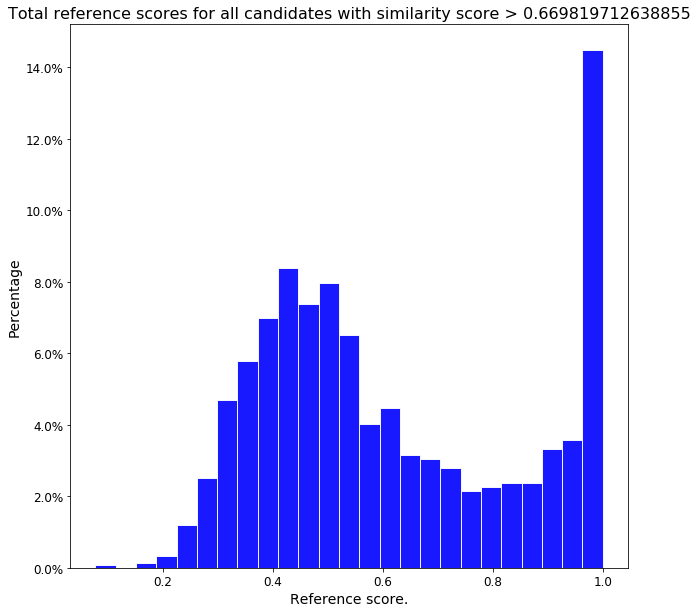

Percentage of highly similar molecules within selection:  54.53 %


In [68]:
num_best = 10000
threshold = np.sort(M_sim_lsi.reshape(M_sim_lsi.shape[0]**2))[-(num_best + M_sim_lsi.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_lsi, tanimoto_similarities_daylight, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_lda.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Searching for cases where molnet and word2vec-based measures disagree a lot

In [34]:
from MS_functions import evaluate_measure
num_candidates = 11
mol_sim, spec_sim, spec_idx, reference_list = evaluate_measure(spectra_dict, spectra,
                                                                  MS_measure, 
                                                                   fingerprints,
                                                                   num_candidates = num_candidates,
                                                                   num_of_molecules = "all", #5000,
                                                                   similarity_method = "centroid", #"molnet",
                                                                   reference_list = None)


  Evaluate spectrum  9550  of  9550  spectra. Evaluate spectrum  2560  of  9550  spectra. spectra.  of  9550  spectra.

In [35]:
from MS_functions import evaluate_measure
num_candidates = 11
mol_sim2, spec_sim2, spec_idx2, reference_list2 = evaluate_measure(spectra_dict, spectra,
                                                                  MS_measure, 
                                                                   fingerprints,
                                                                   num_candidates = num_candidates,
                                                                   num_of_molecules = "all", #5000,
                                                                   similarity_method = "molnet",
                                                                   molnet_sim = molnet_sim,
                                                                   reference_list = None)

  Evaluate spectrum  9550  of  9550  spectra.  spectra.

## Further tests with other measure (lsi, pca etc.)

Compare to word2vec and also test combinations!

### Try different similarity measuring methods...

#### A) LSI
LSI topic modeling....

In [240]:
file_model_lsi =  PATH_SAVE_MODEL + 'model_lsi_MS_uniquesmiles_topic300_iter20_loss500_minpeak10_dec2.model' 
MS_measure.build_model_lsi(file_model_lsi, num_of_topics=300, num_iter=20, use_stored_model=True)

Stored LSI model not found!
Calculating new LSI model...


In [241]:
MS_measure.get_lsi_similarity(num_hits=25)

In [243]:
import gensim
from gensim.test.utils import get_tmpfile
index_tmpfile = get_tmpfile("index")
index = gensim.similarities.Similarity(index_tmpfile, MS_measure.model_lsi[MS_measure.bow_corpus], 
                                       num_features=len(MS_measure.dictionary))  # build the index
M_sim_lsi = np.zeros((len(MS_measure.corpus), len(MS_measure.corpus)))
for i, similarities in enumerate(index):  # yield similarities of all indexed documents
    M_sim_lsi[:,i] = similarities

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

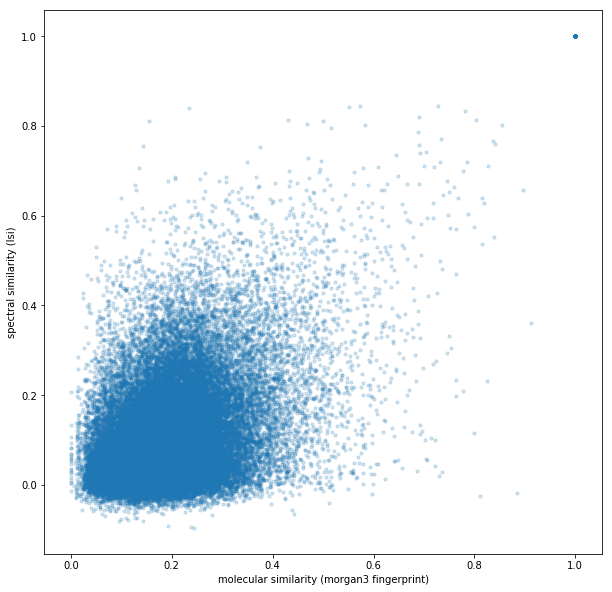

In [248]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_m3[:300,:300], M_sim_lsi[:300,:300], s=10, alpha=0.1)
plt.ylabel("spectral similarity (lsi)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

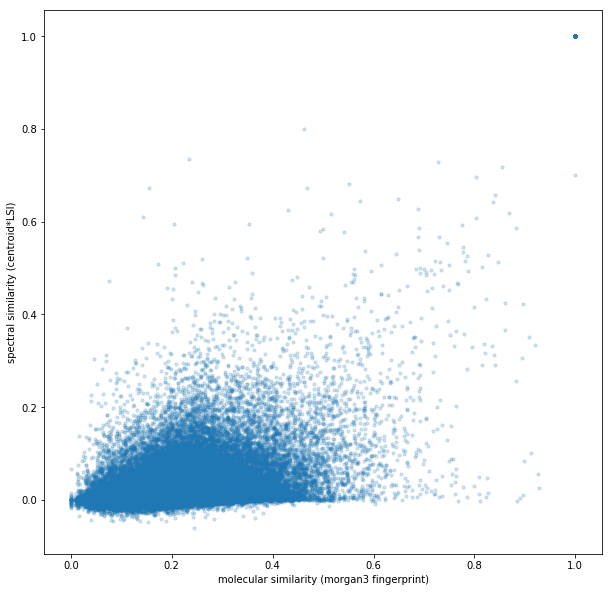

In [267]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_m3[:400,:400], M_sim_ctr[:400,:400]*M_sim_lsi[:400,:400], s=10, alpha=0.1)
plt.ylabel("spectral similarity (centroid*LSI)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

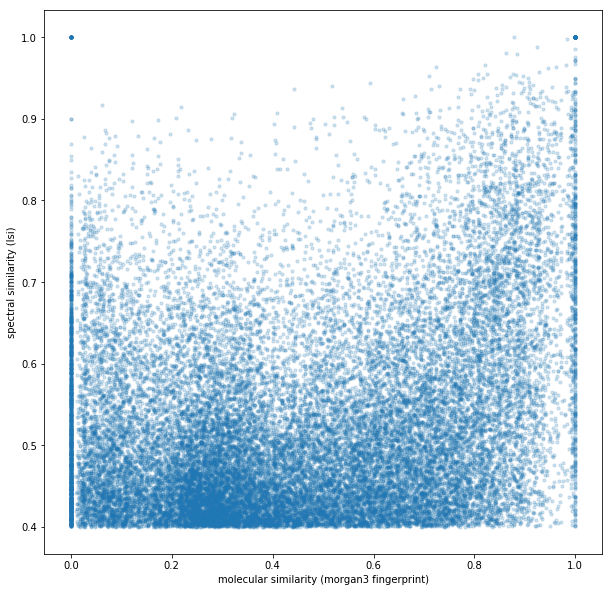

In [269]:
fig, ax = plt.subplots(figsize=(10,10))
#select = np.where(tanimoto_similarities_m3 > 0.7)
select = np.where(M_sim_lsi*M_sim_ctr > 0.4)
ax.scatter(tanimoto_similarities_m3[select], M_sim_lsi[select]*M_sim_ctr[select], s=10, alpha=0.1)
plt.ylabel("spectral similarity (lsi)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

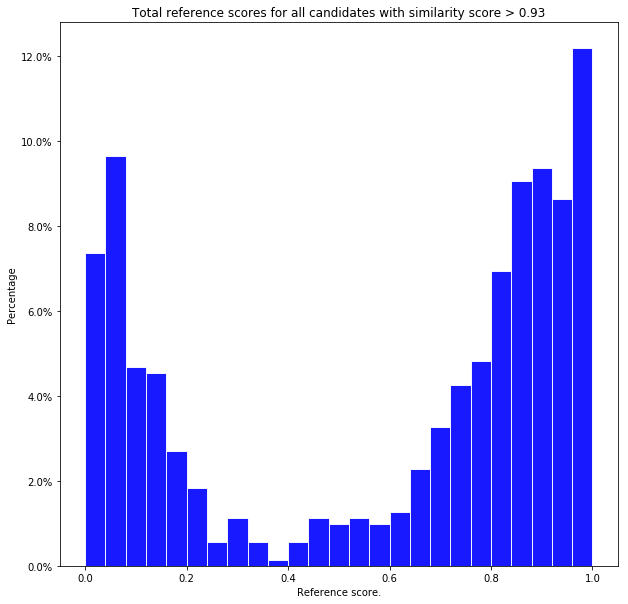

In [262]:
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]
n, bins = MS_functions.similarity_histogram(M_sim_lsi, tanimoto_similarities_m3, 0.93, 
                                            num_bins=25, exclude_IDs = exclude)

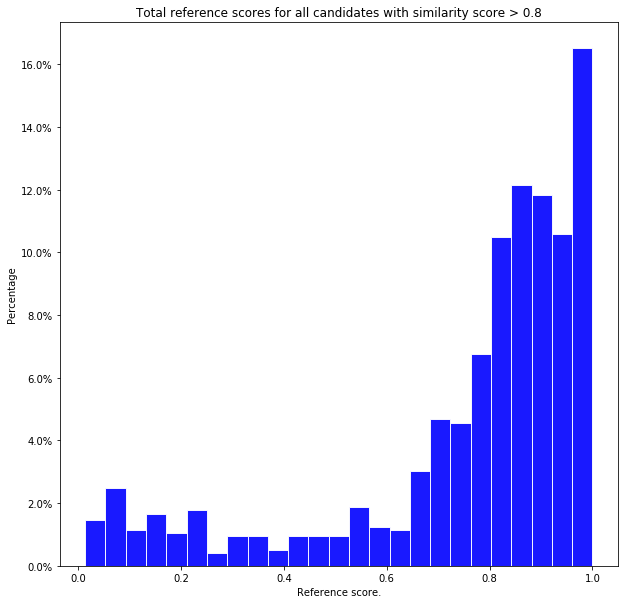

In [264]:

n, bins = MS_functions.similarity_histogram(M_sim_ctr*M_sim_lsi, tanimoto_similarities_m3, 0.8, 
                                            num_bins=25, exclude_IDs = exclude)